# Préparation des features pour la modélisation

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.axes import Axes
import seaborn as sns
import numpy as np
from scipy import stats
from typing import List

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Constantes
TARGET_CO2 = 'TotalGHGEmissions'
TARGET_ENERGY = 'SiteEnergyUse(kBtu)'
CIBLES = [TARGET_CO2, TARGET_ENERGY]

# Chargement des données
df_origin = pd.read_csv('data/data_feature_engineering.csv')

df = df_origin.copy()

print(f"📊 Dataset chargé")
print(f"   Shape : {df.shape}")
print(f"   Lignes : {len(df):,} bâtiments")
print(f"   Colonnes : {df.shape[1]}")


📊 Dataset chargé
   Shape : (1630, 65)
   Lignes : 1,630 bâtiments
   Colonnes : 65


## 1. Suppression des colonnes

### Suppression des colonnes peu pertinentes
Nettoyer le dataset en supprimant les colonnes qui n'apportent aucune information utile pour l'analyse et la modélisation.

In [48]:
def display_columns_info(df: pd.DataFrame, columns: List[str]):
    for col in columns:
        n_unique = df[col].nunique()
        n_missing = df[col].isna().sum()
        pct_unique = (n_unique / len(df)) * 100
        pct_missing = (n_missing / len(df)) * 100
        
        print(f"• {col}:")
        print(f"  - Type : {df[col].dtype}")
        print(f"  - Valeurs uniques: {n_unique} ({pct_unique:.1f}%)")
        print(f"  - Valeurs manquantes: {n_missing} ({pct_missing:.1f}%)")
        
        # Afficher les valeurs si peu nombreuses
        if n_unique <= 10:
            print(f"  - Valeurs: {df[col].unique()}")
        print("")
        
low_predictive_value_columns = [
    'DataYear', 
    'City', 
    'State',
	'OSEBuildingID', 
    'PropertyName', 
    'Address', 
    'TaxParcelIdentificationNumber',
	'DefaultData', 
    'ComplianceStatus',
    'ListOfAllPropertyUseTypes',
    'LargestPropertyUseType'
]
display_columns_info(df, low_predictive_value_columns)

• DataYear:
  - Type : int64
  - Valeurs uniques: 1 (0.1%)
  - Valeurs manquantes: 0 (0.0%)
  - Valeurs: [2016]

• City:
  - Type : object
  - Valeurs uniques: 1 (0.1%)
  - Valeurs manquantes: 0 (0.0%)
  - Valeurs: ['Seattle']

• State:
  - Type : object
  - Valeurs uniques: 1 (0.1%)
  - Valeurs manquantes: 0 (0.0%)
  - Valeurs: ['WA']

• OSEBuildingID:
  - Type : int64
  - Valeurs uniques: 1630 (100.0%)
  - Valeurs manquantes: 0 (0.0%)

• PropertyName:
  - Type : object
  - Valeurs uniques: 1626 (99.8%)
  - Valeurs manquantes: 0 (0.0%)

• Address:
  - Type : object
  - Valeurs uniques: 1609 (98.7%)
  - Valeurs manquantes: 0 (0.0%)

• TaxParcelIdentificationNumber:
  - Type : object
  - Valeurs uniques: 1549 (95.0%)
  - Valeurs manquantes: 0 (0.0%)

• DefaultData:
  - Type : bool
  - Valeurs uniques: 2 (0.1%)
  - Valeurs manquantes: 0 (0.0%)
  - Valeurs: [False  True]

• ComplianceStatus:
  - Type : object
  - Valeurs uniques: 2 (0.1%)
  - Valeurs manquantes: 0 (0.0%)
  - Valeurs: ['Co

##### Colonnes à valeur unique (3)
Ces colonnes contiennent la même valeur pour tous les bâtiments, elles n'apportent donc aucune variabilité ni pouvoir discriminant.

| Colonne | Valeur unique | Raison |
|---------|---------------|--------|
| `DataYear` | 2016 | Toutes les observations datent de 2016 |
| `City` | Seattle | Tous les bâtiments sont situés à Seattle |
| `State` | WA | Tous les bâtiments sont dans l'État de Washington |

##### Identifiants uniques (4)
Ces colonnes identifient de manière unique chaque bâtiment mais ne permettent pas de généraliser à de nouveaux bâtiments.

| Colonne | Taux d'unicité | Raison |
|---------|----------------|--------|
| `OSEBuildingID` | 100% | Identifiant système unique par bâtiment |
| `PropertyName` | 99.8% | Nom propre du bâtiment (ex: "Mayflower Park Hotel") |
| `Address` | 98.7% | Adresse complète spécifique à chaque bâtiment |
| `TaxParcelIdentificationNumber` | 95% | Numéro de parcelle fiscale unique |

##### Métadonnées (2)
Ces colonnes concernent la qualité et le statut des données, pas les caractéristiques des bâtiments.

| Colonne | Type | Raison |
|---------|------|--------|
| `DefaultData` | Booléen | Indique si les données sont estimées ou réelles |
| `ComplianceStatus` | Texte | Statut de conformité réglementaire ("Compliant" ou "Error") |

##### Données inutiles

| Colonne | Modalités | Raison de suppression | Remplacement |
|---------|-----------|----------------------|--------------|
| `ListOfAllPropertyUseTypes` | 365 | Cardinalité trop élevée + redondance | `has_multiple_uses` + `use_count` + features binaires d'usage |
| `LargestPropertyUseType` | 55 | Haute cardinalité + redondance | `PrimaryPropertyType` (22 modalités) |

In [49]:
def remove_columns(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Supprime les colonnes spécifiées du DataFrame.

    Args:
        df (pd.DataFrame): Le DataFrame d'origine.
        columns (list): Liste des noms de colonnes à supprimer.

    Returns:
        pd.DataFrame: Le DataFrame sans les colonnes supprimées.
    """
    print("\n📦 Suppression de colonnes")
    print(f"   ➤ Shape initiale        : {df.shape}")
    print(f"   ➤ Colonnes demandées    : {len(columns)}")

    # Colonnes réellement présentes
    existing_cols = [col for col in columns if col in df.columns]
    missing_cols = [col for col in columns if col not in df.columns]

    df = df.drop(columns=existing_cols)

    print(f"✅ Suppression terminée")
    print(f"   ➤ Shape finale          : {df.shape}")
    print(f"   ➤ Colonnes supprimées   : {len(existing_cols)}")

    if existing_cols:
        print(f"   🧹 Liste supprimée       : {existing_cols}")

    if missing_cols:
        print(f"   ⚠️ Colonnes inexistantes : {missing_cols}")

    return df
df = remove_columns(df, low_predictive_value_columns)


📦 Suppression de colonnes
   ➤ Shape initiale        : (1630, 65)
   ➤ Colonnes demandées    : 11
✅ Suppression terminée
   ➤ Shape finale          : (1630, 54)
   ➤ Colonnes supprimées   : 11
   🧹 Liste supprimée       : ['DataYear', 'City', 'State', 'OSEBuildingID', 'PropertyName', 'Address', 'TaxParcelIdentificationNumber', 'DefaultData', 'ComplianceStatus', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType']


###  Suppression des colonnes causant du data leakage

**Qu'est-ce que le data leakage ?**

Le **data leakage** (fuite de données) se produit quand des informations de la cible sont utilisées dans les features d'entraînement. Cela crée une **performance artificielle** en entraînement mais un **échec total** en production.

| Colonne | Explication détaillée |
|---------|----------------------|
| `Electricity(kBtu)` | Cette variable **constitue directement la cible**. C'est un terme de la somme : `SiteEnergyUse(kBtu) = Electricity(kBtu) + NaturalGas(kBtu) + SteamUse(kBtu)`. Prédire une somme en utilisant l’un de ses termes revient à un leakage parfait. |
| `Electricity(kWh)` | Identique à `Electricity(kBtu)` mais en unités différentes |
| `NaturalGas(kBtu)` | Cette variable **constitue directement la cible**. Elle est l’un des termes de la relation : `SiteEnergyUse(kBtu) = Electricity(kBtu) + NaturalGas(kBtu) + SteamUse(kBtu)`. Utiliser cette information revient à injecter une partie exacte de la target. |
| `NaturalGas(therms)` | Identique à `NaturalGas(kBtu)` mais en unités différentes |
| `SteamUse(kBtu)` | Cette variable **constitue directement la cible**. Elle correspond à un terme explicite de la somme : `SiteEnergyUse(kBtu) = Electricity(kBtu) + NaturalGas(kBtu) + SteamUse(kBtu)`. C’est un cas de fuite d’information déterministe. |
| `SiteEnergyUseWN(kBtu)` | Version "Weather Normalized" de votre target `SiteEnergyUse(kBtu)`. C'est votre target ajustée pour la météo. Corrélation quasi-parfaite = information quasi-identique. |
| `SiteEUI(kBtu/sf)` | **Site Energy Use Intensity** = `SiteEnergyUse(kBtu) / PropertyGFABuilding(s)`. C'est votre target Energy divisée par la surface. Formule mathématique directe. |
| `SiteEUIWN(kBtu/sf)` | Version "Weather Normalized" de `SiteEUI`. Calculée à partir de `SiteEnergyUseWN / Surface`. Double problème : dérivée de la target + normalisée. |
| `SourceEUI(kBtu/sf)` | **Source Energy Use Intensity** incluant les pertes de distribution (transport électricité, etc.). Calculée à partir de la consommation réelle. |
| `SourceEUIWN(kBtu/sf)` | Version normalisée de `SourceEUI`. Dérivée de consommations réelles + ajustements météo. |
| `GHGEmissionsIntensity` | **Optionnelle selon stratégie**. Intensité des émissions = `TotalGHGEmissions / Surface`. Si vous prédisez CO2, c'est votre target divisée. Si vous prédisez Energy, risque de leakage via corrélation avec CO2 (0.86). |

In [50]:
features_leakage = [
    'Electricity(kWh)',
    'Electricity(kBtu)',
    'NaturalGas(therms)',
    'NaturalGas(kBtu)',
    'SteamUse(kBtu)',
    'SiteEnergyUseWN(kBtu)',
    'SiteEUI(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'GHGEmissionsIntensity'
]
df = remove_columns(df, features_leakage)


📦 Suppression de colonnes
   ➤ Shape initiale        : (1630, 54)
   ➤ Colonnes demandées    : 11
✅ Suppression terminée
   ➤ Shape finale          : (1630, 43)
   ➤ Colonnes supprimées   : 11
   🧹 Liste supprimée       : ['Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'GHGEmissionsIntensity']


## 2.  Analyse des variables cibles

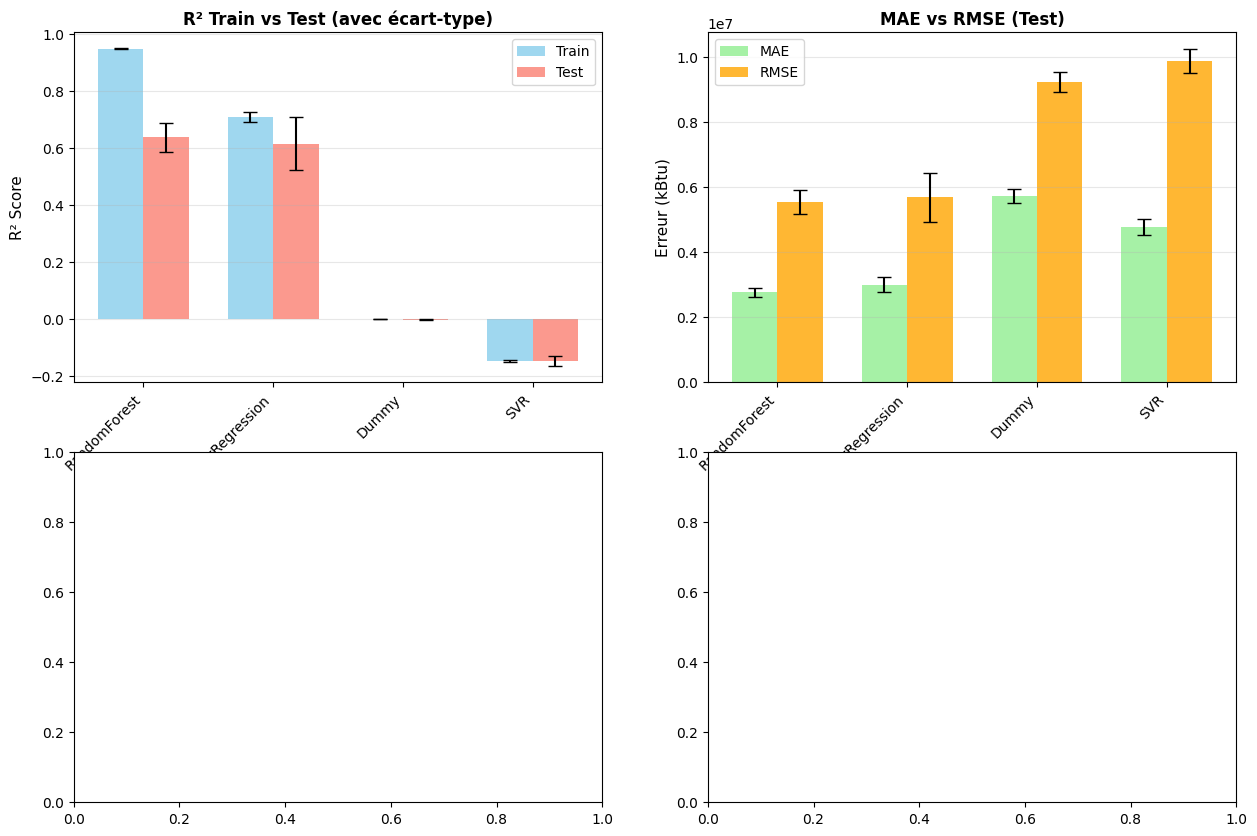

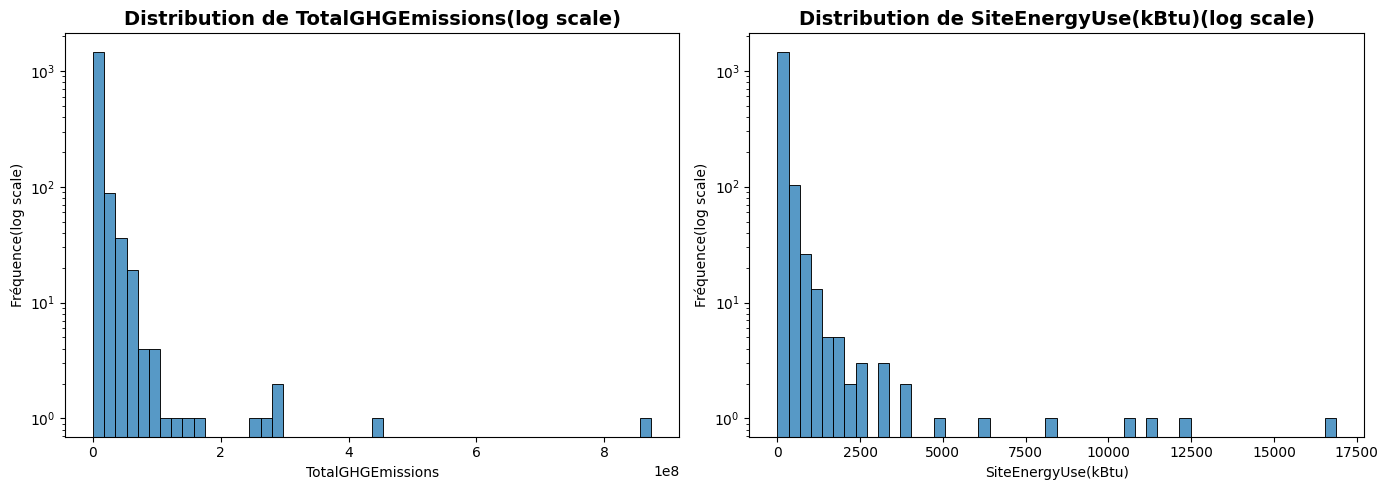

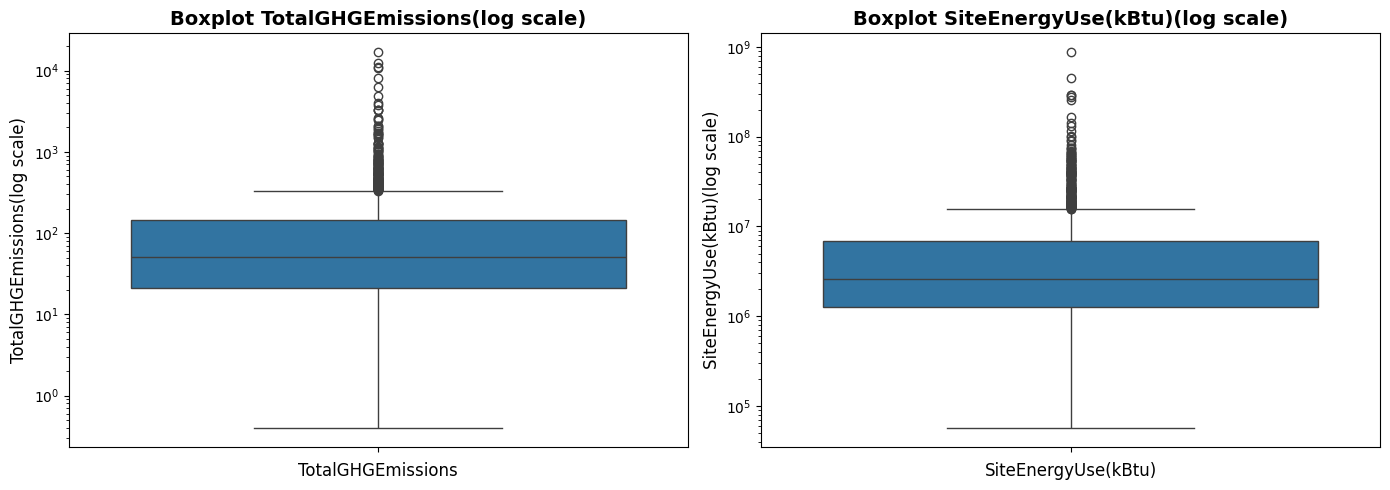

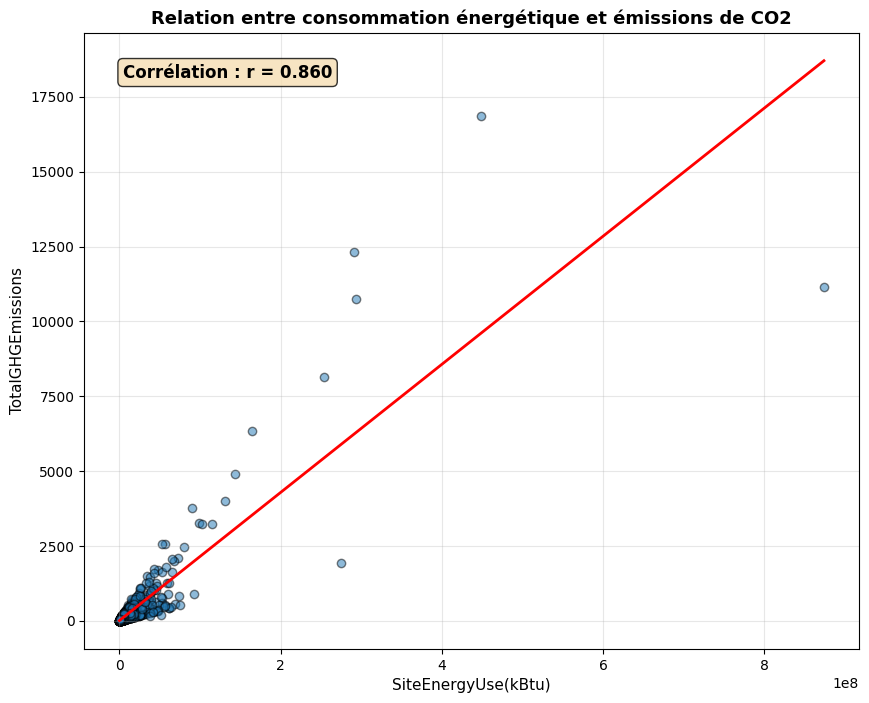

In [51]:
def create_histogram(
    df: pd.DataFrame,
    column: str,
    title: str,
    xlabel: str,
    ylabel: str,
    ax: plt.Axes,
    log_scale: bool = False
):
    sns.histplot(
        data=df,
        x=column,
        bins=50,
        kde=False,
        ax=ax,
        edgecolor='black'
    )

    if log_scale:
        ax.set_yscale("log")
        title = title + "(log scale)"
        ylabel = ylabel + "(log scale)"

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def create_boxplot(
    df: pd.DataFrame,
    y_col: str,
    ax: plt.Axes,
    x_col: str = None,
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    rotate_x: int = 0,
    log_scale: bool = False
):
    sns.boxplot(
        data=df,
        x=x_col,
        y=y_col,
        ax=ax
    )

    if log_scale:
        ax.set_yscale("log")
        title = title + "(log scale)"
        ylabel = ylabel + "(log scale)"

    if rotate_x:
        ax.tick_params(axis='x', rotation=rotate_x)


    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

def create_scatter(
    df: pd.DataFrame,
    var1: str,
    var2: str,
    title: str,
    xlabel: str,
    ylabel: str,
    ax: plt.Axes,
    add_trendline: bool = False,
    add_corr: bool = False,
):
    if add_trendline:
        sns.regplot(
            data=df,
            x=var1,
            y=var2,
            ax=ax,
            scatter_kws={
                "alpha": 0.5,
                "edgecolor": "k"
            },
            line_kws={
                "color": "red",
                "linewidth": 2
            },
            ci=None
        )
    else:
        sns.scatterplot(
            data=df,
            x=var1,
            y=var2,
            ax=ax,
            alpha=0.5,
            edgecolor="k"
        )

    if add_corr:
        corr = df[var1].corr(df[var2])
        ax.text(0.05, 0.95, f'Corrélation : r = {corr:.3f}',
            transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            verticalalignment='top', fontsize=12, fontweight='bold'
        )
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.grid(True, alpha=0.3)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

create_histogram(
    df,
    TARGET_ENERGY,
    'Distribution de TotalGHGEmissions',
    'TotalGHGEmissions',
    'Fréquence',
    axes[0],
    log_scale=True

)


create_histogram(
    df,
    TARGET_CO2,
    'Distribution de SiteEnergyUse(kBtu)',
    'SiteEnergyUse(kBtu)',
    'Fréquence',
    axes[1],
    log_scale=True
)

plt.tight_layout()
plt.show()


# Boxplots pour identifier les outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

create_boxplot(
    df,
    y_col=TARGET_ENERGY,
    title='Boxplot SiteEnergyUse(kBtu)',
    xlabel='SiteEnergyUse(kBtu)',
    ylabel='SiteEnergyUse(kBtu)',
    ax=axes[1],
    log_scale=True
)

create_boxplot(
    df,
    y_col=TARGET_CO2,
    title='Boxplot TotalGHGEmissions',
    xlabel='TotalGHGEmissions',
    ylabel='TotalGHGEmissions',
    ax=axes[0],
    log_scale=True
)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))

create_scatter(df, TARGET_ENERGY, TARGET_CO2, "Relation entre consommation énergétique et émissions de CO2", TARGET_ENERGY, TARGET_CO2, ax, True, True)
plt.show()

#### Analyse des graphiques

- **TotalGHGEmissions** :  
  La distribution est très étalée vers la droite. On observe que la plupart des valeurs sont faibles, mais quelques bâtiments ont des émissions très élevées. Ces valeurs extrêmes (outliers) influencent fortement la distribution. Le boxplot montre une médiane plutôt basse et une grande dispersion. L'utilisation de l'échelle logarithmique révèle que les données couvrent plusieurs ordres de grandeur, ce qui explique l'importance de cette transformation pour visualiser l'ensemble de la distribution.

- **SiteEnergyUse (kBtu)** :  
  La consommation d'énergie est elle aussi majoritairement faible à modérée pour la plupart des sites. Cependant, certains bâtiments consomment énormément d'énergie, ce qui crée des outliers visibles sur le boxplot. La distribution n'est donc pas symétrique. Comme pour les émissions, l'échelle logarithmique permet de mieux appréhender la variabilité importante des données, qui s'étendent sur plusieurs ordres de grandeur.

- **Relation entre consommation énergétique et émissions de CO2** :  
  Le graphique 3 révèle une corrélation forte (r = 0.798) entre la consommation d'énergie des sites et leurs émissions de gaz à effet de serre. Cette relation positive indique que les bâtiments qui consomment le plus d'énergie sont également ceux qui émettent le plus de CO2, ce qui est cohérent d'un point de vue physique et souligne l'importance de cibler ces bâtiments énergivores pour réduire les émissions.

**Conclusion** :  
Les deux variables présentent des distributions asymétriques avec beaucoup de valeurs extrêmes. La forte corrélation observée entre consommation énergétique et émissions confirme le lien direct entre ces deux aspects. Pour aller plus loin dans l'analyse, il pourrait être utile de traiter les outliers afin d'obtenir des résultats plus stables.

## 3. Gestion des outliers

COMPARAISON DES MÉTHODES DE DÉTECTION D'OUTLIERS

Données totales : 1630 bâtiments
   Moyenne : 188 kBtu
   Médiane : 50 kBtu
   Écart-type : 760 kBtu

MÉTHODE 1 : Z-SCORE (seuil = 2)
Nombre d'outliers : 21
Pourcentage : 1.29%

MÉTHODE 2 : Z-SCORE (seuil = 3)
Nombre d'outliers : 14
Pourcentage : 0.86%

MÉTHODE 3 : IQR (facteur = 1.5)
Seuil bas : -165 kBtu
Seuil haut : 330 kBtu
Nombre d'outliers : 170
Pourcentage : 10.43%


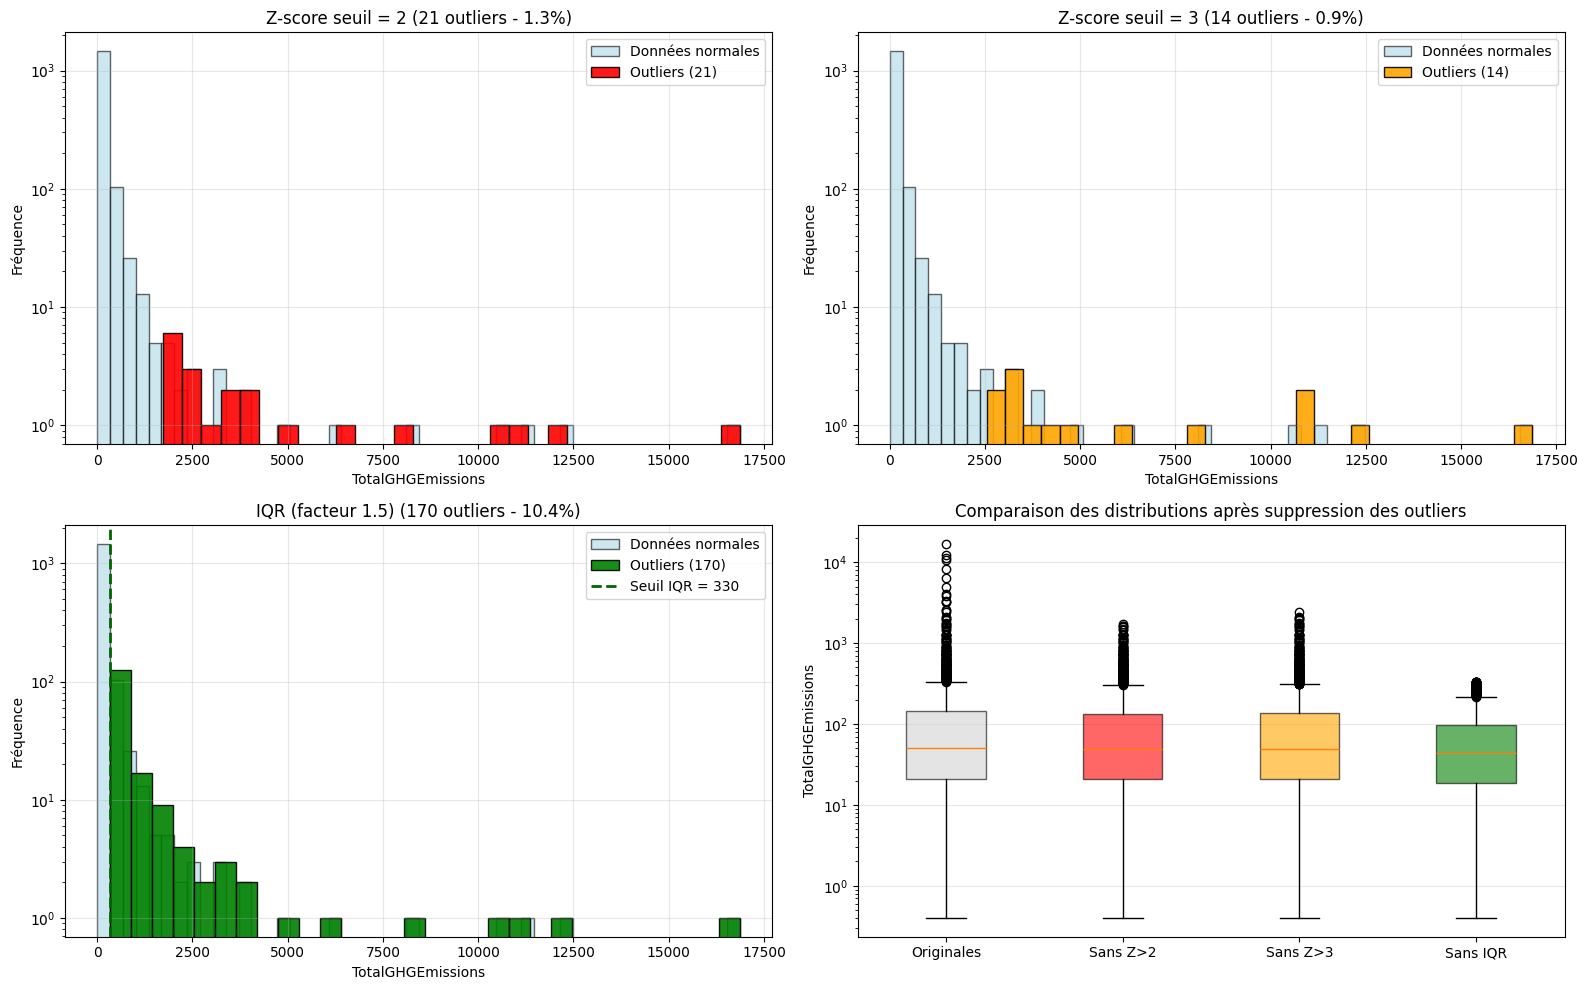

COMPARAISON DES MÉTHODES DE DÉTECTION D'OUTLIERS

Données totales : 1630 bâtiments
   Moyenne : 8,558,875 kBtu
   Médiane : 2,617,531 kBtu
   Écart-type : 30,539,466 kBtu

MÉTHODE 1 : Z-SCORE (seuil = 2)
Nombre d'outliers : 18
Pourcentage : 1.10%

MÉTHODE 2 : Z-SCORE (seuil = 3)
Nombre d'outliers : 11
Pourcentage : 0.67%

MÉTHODE 3 : IQR (facteur = 1.5)
Seuil bas : -7,273,131 kBtu
Seuil haut : 15,505,047 kBtu
Nombre d'outliers : 184
Pourcentage : 11.29%


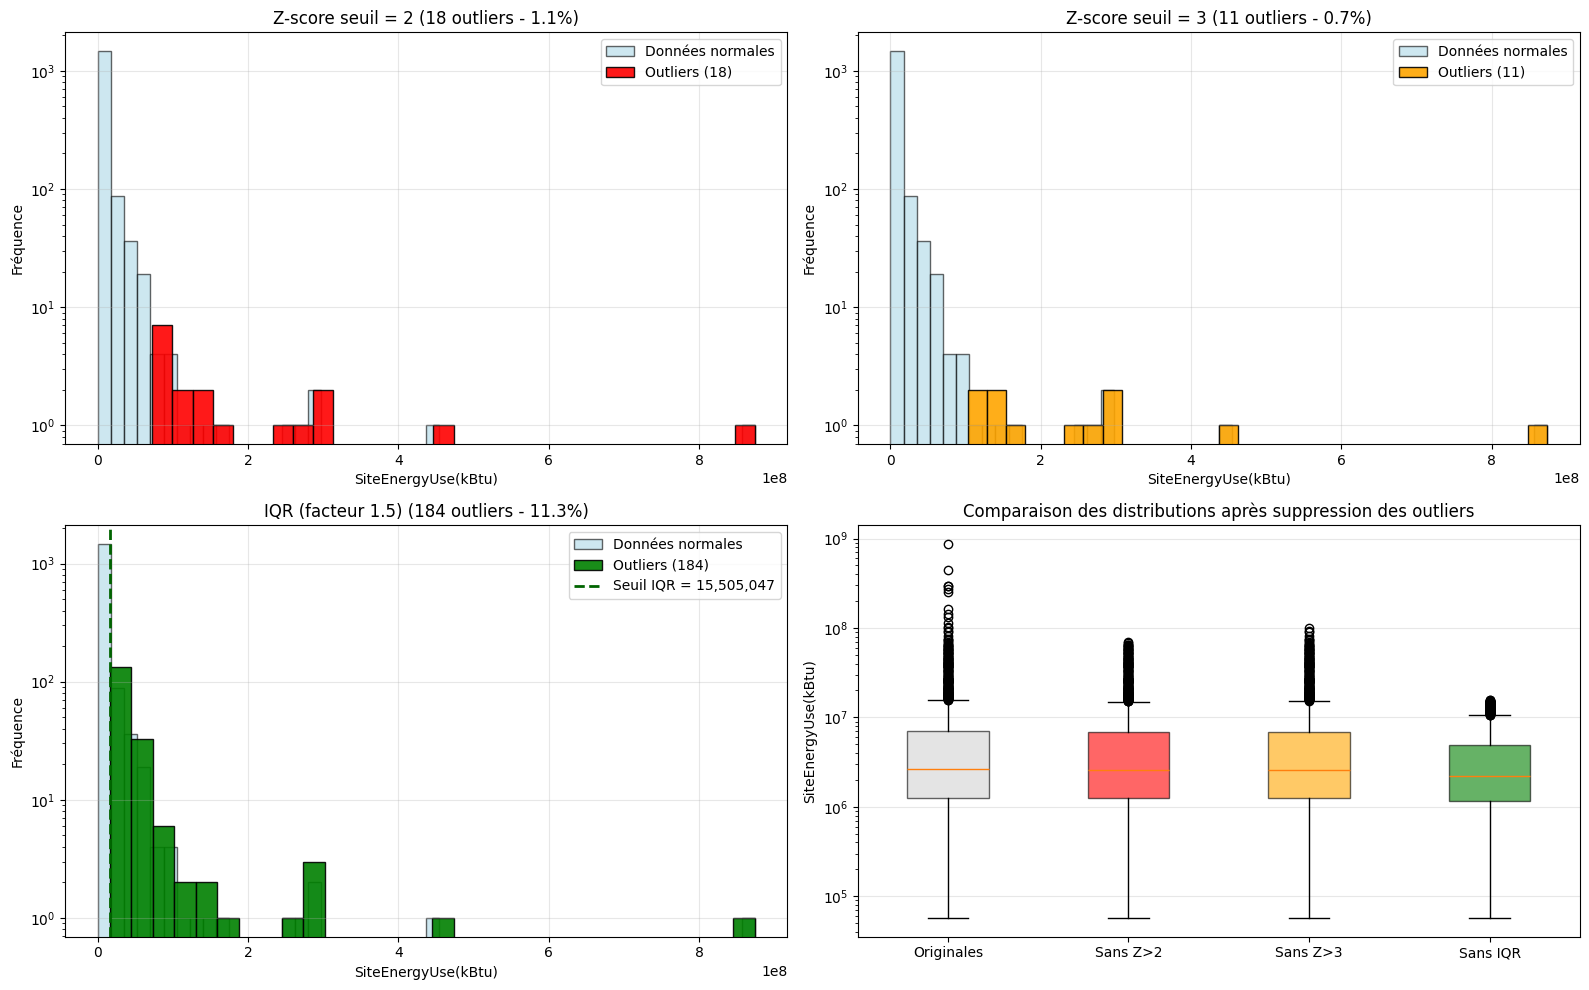

In [52]:
# ========================================
# COMPARAISON Z-SCORE vs IQR
# ========================================
for cible in CIBLES:

    # 1. Calcul Z-score
    z_scores = stats.zscore(df[cible].dropna())
    abs_z_scores = np.abs(z_scores)

    # 2. Calcul IQR
    Q1 = df[cible].quantile(0.25)
    Q3 = df[cible].quantile(0.75)
    IQR = Q3 - Q1
    lower_iqr = Q1 - 1.5 * IQR
    upper_iqr = Q3 + 1.5 * IQR

    # Identification des outliers
    outliers_z2 = df[cible].dropna()[abs_z_scores > 2]
    outliers_z3 = df[cible].dropna()[abs_z_scores > 3]
    outliers_iqr = df[(df[cible] < lower_iqr) | 
                                (df[cible] > upper_iqr)][cible]
    
    # Créer une colonne indicatrice
    df[f'{cible}_outlier_z_score_2'] = abs_z_scores > 2
    df[f'{cible}_outlier_z_score_3'] = abs_z_scores > 3
    df[f'{cible}_outlier_IQR'] = (df[cible] < lower_iqr) | (df[cible] > upper_iqr)

    # ========================================
    # RÉSULTATS COMPARATIFS
    # ========================================
    print("=" * 70)
    print("COMPARAISON DES MÉTHODES DE DÉTECTION D'OUTLIERS")
    print("=" * 70)

    print(f"\nDonnées totales : {len(df)} bâtiments")
    print(f"   Moyenne : {df[cible].mean():,.0f} kBtu")
    print(f"   Médiane : {df[cible].median():,.0f} kBtu")
    print(f"   Écart-type : {df[cible].std():,.0f} kBtu")

    print("\n" + "=" * 70)
    print("MÉTHODE 1 : Z-SCORE (seuil = 2)")
    print("=" * 70)
    print(f"Nombre d'outliers : {len(outliers_z2)}")
    print(f"Pourcentage : {(len(outliers_z2) / len(df) * 100):.2f}%")

    print("\n" + "=" * 70)
    print("MÉTHODE 2 : Z-SCORE (seuil = 3)")
    print("=" * 70)
    print(f"Nombre d'outliers : {len(outliers_z3)}")
    print(f"Pourcentage : {(len(outliers_z3) / len(df) * 100):.2f}%")

    print("\n" + "=" * 70)
    print("MÉTHODE 3 : IQR (facteur = 1.5)")
    print("=" * 70)
    print(f"Seuil bas : {lower_iqr:,.0f} kBtu")
    print(f"Seuil haut : {upper_iqr:,.0f} kBtu")
    print(f"Nombre d'outliers : {len(outliers_iqr)}")
    print(f"Pourcentage : {(len(outliers_iqr) / len(df) * 100):.2f}%")

    # ========================================
    # VISUALISATION COMPARATIVE
    # ========================================
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Graphique 1 : Z-score = 2
    axes[0, 0].hist(df[cible].dropna(), bins=50, alpha=0.6, 
                    label='Données normales', edgecolor='black', color='lightblue')
    axes[0, 0].hist(outliers_z2, bins=30, alpha=0.9, 
                    label=f'Outliers ({len(outliers_z2)})', color='red', edgecolor='black')
    axes[0, 0].set_xlabel(cible)
    axes[0, 0].set_ylabel('Fréquence')
    axes[0, 0].set_title(f'Z-score seuil = 2 ({len(outliers_z2)} outliers - {(len(outliers_z2)/len(df)*100):.1f}%)')
    axes[0, 0].legend()
    axes[0, 0].set_yscale('log')
    axes[0, 0].grid(alpha=0.3)

    # Graphique 2 : Z-score = 3
    axes[0, 1].hist(df[cible].dropna(), bins=50, alpha=0.6, 
                    label='Données normales', edgecolor='black', color='lightblue')
    axes[0, 1].hist(outliers_z3, bins=30, alpha=0.9, 
                    label=f'Outliers ({len(outliers_z3)})', color='orange', edgecolor='black')
    axes[0, 1].set_xlabel(cible)
    axes[0, 1].set_ylabel('Fréquence')
    axes[0, 1].set_title(f'Z-score seuil = 3 ({len(outliers_z3)} outliers - {(len(outliers_z3)/len(df)*100):.1f}%)')
    axes[0, 1].legend()
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(alpha=0.3)

    # Graphique 3 : IQR
    axes[1, 0].hist(df[cible].dropna(), bins=50, alpha=0.6, 
                    label='Données normales', edgecolor='black', color='lightblue')
    axes[1, 0].hist(outliers_iqr, bins=30, alpha=0.9, 
                    label=f'Outliers ({len(outliers_iqr)})', color='green', edgecolor='black')
    axes[1, 0].axvline(upper_iqr, color='darkgreen', linestyle='--', linewidth=2, 
                    label=f'Seuil IQR = {upper_iqr:,.0f}')
    axes[1, 0].set_xlabel(cible)
    axes[1, 0].set_ylabel('Fréquence')
    axes[1, 0].set_title(f'IQR (facteur 1.5) ({len(outliers_iqr)} outliers - {(len(outliers_iqr)/len(df)*100):.1f}%)')
    axes[1, 0].legend()
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(alpha=0.3)

    # Graphique 4 : Boxplot comparatif
    data_z2 = df[cible].copy()
    data_z2.loc[outliers_z2.index] = np.nan

    data_z3 = df[cible].copy()
    data_z3.loc[outliers_z3.index] = np.nan

    data_iqr = df[cible].copy()
    data_iqr.loc[outliers_iqr.index] = np.nan

    box_data = [
        df[cible].dropna(),
        data_z2.dropna(),
        data_z3.dropna(),
        data_iqr.dropna()
    ]

    bp = axes[1, 1].boxplot(box_data, tick_labels=['Originales', 'Sans Z>2', 'Sans Z>3', 'Sans IQR'],
                            patch_artist=True)
    for patch, color in zip(bp['boxes'], ['lightgray', 'red', 'orange', 'green']):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    axes[1, 1].set_ylabel(cible)
    axes[1, 1].set_title('Comparaison des distributions après suppression des outliers')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

**Observation:**

La comparaison des méthodes de détection des valeurs aberrantes montre que :

- **Z-score (seuil = 2)**  
  Identifie un nombre limité de valeurs aberrantes (environ **1 % des observations**) pour les deux variables.

- **Z-score (seuil = 3)**  
  Plus permissif, il conserve davantage de valeurs extrêmes.

- **Méthode IQR (facteur = 1.5)**  
  Détecte un volume beaucoup plus important d’outliers (environ **10 à 11 %**), ce qui entraîne une réduction significative de la taille du dataset.

Les **boxplots comparatifs** indiquent que :
- la médiane reste globalement stable après suppression des outliers ;
- la dispersion diminue, en particulier avec la méthode **IQR**.

**Choix retenu:**

Le **Z-score avec un seuil de 2** est retenu pour les deux variables cibles.  
Ce choix permet de supprimer uniquement les valeurs les plus extrêmes, tout en conservant un volume de données suffisant pour l’entraînement des modèles de régression et en limitant le risque d’exclure des bâtiments représentatifs de la réalité métier.

In [53]:
print("\n" + "="*80)
print("SUPPRESSION DES OUTLIERS")
print("="*80)
# Supprimer si outlier pour AU MOINS UNE des deux cibles (RECOMMANDÉ)
outliers_mask = df[TARGET_ENERGY + '_outlier_z_score_2'] | df[TARGET_CO2 + '_outlier_z_score_2']


print(f"\nNombre de bâtiments à supprimer : {outliers_mask.sum()} ({outliers_mask.sum()/len(df)*100:.1f}%)")

# Créer le DataFrame nettoyé
df_clean = df[~outliers_mask].copy()

# Supprimer les colonnes indicatrices (optionnel)
remove_columns(df_clean, [
	TARGET_ENERGY + '_outlier_z_score_2', 
	TARGET_CO2 + '_outlier_z_score_2',
	TARGET_ENERGY + '_outlier_z_score_3', 
	TARGET_CO2 + '_outlier_z_score_3',
	TARGET_ENERGY + '_outlier_IQR', 
	TARGET_CO2 + '_outlier_IQR'
])

print(f"\nDimensions APRÈS suppression : {df_clean.shape}")
print(f"Nombre de bâtiments conservés : {len(df_clean)}")
print(f"Nombre de bâtiments supprimés : {len(df) - len(df_clean)}")

df = df_clean


SUPPRESSION DES OUTLIERS

Nombre de bâtiments à supprimer : 24 (1.5%)

📦 Suppression de colonnes
   ➤ Shape initiale        : (1606, 49)
   ➤ Colonnes demandées    : 6
✅ Suppression terminée
   ➤ Shape finale          : (1606, 43)
   ➤ Colonnes supprimées   : 6
   🧹 Liste supprimée       : ['SiteEnergyUse(kBtu)_outlier_z_score_2', 'TotalGHGEmissions_outlier_z_score_2', 'SiteEnergyUse(kBtu)_outlier_z_score_3', 'TotalGHGEmissions_outlier_z_score_3', 'SiteEnergyUse(kBtu)_outlier_IQR', 'TotalGHGEmissions_outlier_IQR']

Dimensions APRÈS suppression : (1606, 49)
Nombre de bâtiments conservés : 1606
Nombre de bâtiments supprimés : 24


## 4. Suppression des features redondantes  

Identifier et supprimer les features redondantes en utilisant une **matrice de corrélation de Pearson** afin de :
- limiter la **multicolinéarité**,  
- simplifier le modèle,  
- améliorer l’interprétabilité et la stabilité des coefficients.

### Principe  

La corrélation de **Pearson** mesure la **relation linéaire** entre deux variables numériques.  
Son coefficient, noté **r**, est compris entre **-1 et 1**.

### Types de corrélation et interprétation  

| Type de corrélation | Valeur du coefficient *r* | Interprétation |
|--------------------|---------------------------|----------------|
| Corrélation positive | r proche de **+1** | Lorsque la valeur d’une variable augmente, l’autre augmente également |
| Aucune corrélation | r proche de **0** | Pas de relation linéaire significative entre les variables |
| Corrélation négative | r proche de **-1** | Lorsque la valeur d’une variable augmente, l’autre diminue |


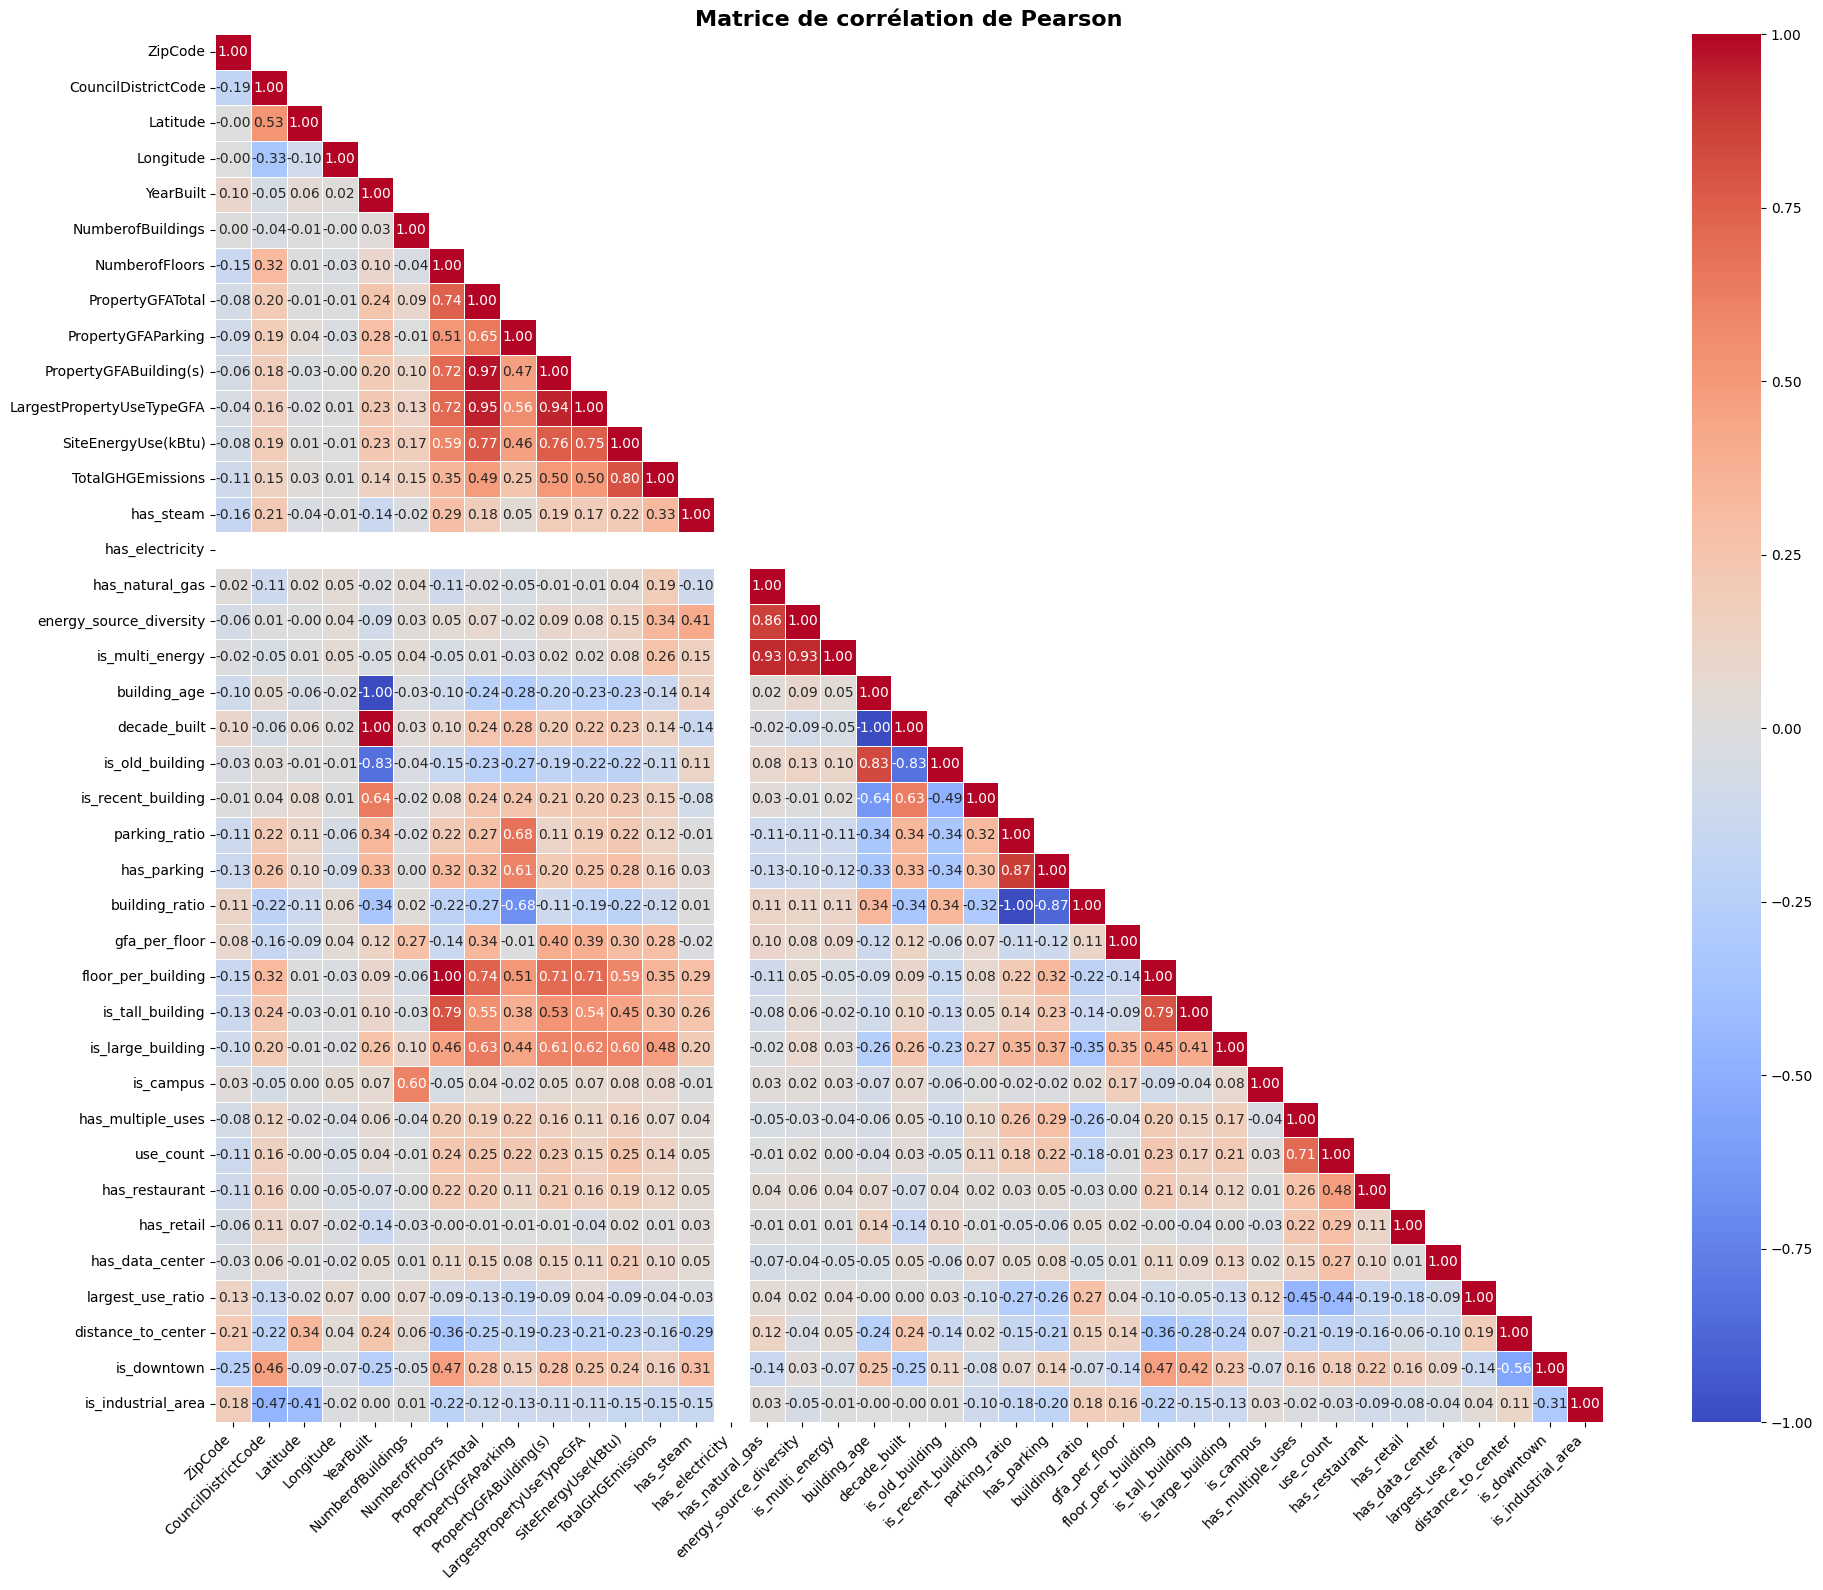

In [54]:
def heatmap_person(df):
    # 1. Calculer la matrice de corrélation
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    corr_matrix = df[numeric_cols].corr()

    # 2. Visualiser avec Seaborn
    plt.figure(figsize=(20, 16))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

    sns.heatmap(corr_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=0.5,
                mask=mask,
                vmin=-1, vmax=1)

    plt.title('Matrice de corrélation de Pearson', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
heatmap_person(df)

#### Analyse de Corrélation - Features Redondantes

**Features Hautement Corrélées (|r| ≥ 0.80)**

| Feature 1                      | Feature 2                      | Corrélation | Choix                                             |
|--------------------------------|--------------------------------|-------------|---------------------------------------------------|
| YearBuilt                      | decade_built                   | 1.00        | ❌ Supprimer YearBuilt                            |
| YearBuilt                      | building_age                   | ~-1.00      | ❌ Supprimer YearBuilt                            |
| decade_built                   | building_age                   | 1.00        | ❌ Supprimer decade_built                         |
| NumberofFloors                 | floor_per_building             | 1.00        | ❌ Supprimer floor_per_building (identiques)      |
| parking_ratio                  | building_ratio                 | -1.00       | ❌ Supprimer parking_ratio                        |
| PropertyGFATotal               | LargestPropertyUseTypeGFA      | 0.97        | ❌ Supprimer LargestPropertyUseTypeGFA            |
| PropertyGFATotal               | PropertyGFABuilding(s)         | 0.97        | ❌ Supprimer PropertyGFABuilding(s)               |
| PropertyGFAParking             | PropertyGFATotal               | 0.93        | ❌ Supprimer PropertyGFAParking                   |
| PropertyGFAParking             | PropertyGFABuilding(s)         | 0.97        | ❌ Supprimer PropertyGFAParking                   |
| LargestPropertyUseTypeGFA      | PropertyGFABuilding(s)         | 0.95        | ❌ Supprimer LargestPropertyUseTypeGFA            |
| is_multi_energy                | energy_source_diversity        | 0.93        | ❌ Supprimer is_multi_energy                      |
| is_multi_energy                | has_natural_gas                | 0.93        | ❌ Supprimer is_multi_energy                      |
| has_parking                    | parking_ratio                  | 0.87        | ❌ Supprimer has_parking (dérivée)                |
| has_parking                    | building_ratio                 | -0.87       | ❌ Supprimer has_parking                          |
| energy_source_diversity        | has_natural_gas                | 0.86        | ❌ Supprimer energy_source_diversity              |
| is_old_building                | building_age                   | -0.83       | ❌ Supprimer is_old_building (dérivée)            |
| is_old_building                | decade_built                   | -0.83       | ❌ Supprimer is_old_building (dérivée)            |

**Features Modérément Corrélées (0.70 ≤ |r| < 0.80)**

| Feature 1                      | Feature 2                      | Corrélation | Choix                                             |
|--------------------------------|--------------------------------|-------------|---------------------------------------------------|
| SiteEnergyUse(kBtu)            | LargestPropertyUseTypeGFA      | 0.79        | ✅ Garder les deux (relation causale légitime)    |
| is_tall_building               | NumberofFloors                 | 0.79        | ❌ Supprimer is_tall_building (dérivée)           |
| is_tall_building               | floor_per_building             | 0.79        | ❌ Supprimer is_tall_building (dérivée)           |
| TotalGHGEmissions              | SiteEnergyUse(kBtu)            | 0.77        | ✅ Garder les deux (relation causale importante)  |
| PropertyGFATotal               | NumberofFloors                 | 0.74        | ✅ Garder les deux (relation causale légitime)    |
| use_count                      | has_multiple_uses              | 0.71        | ❌ Supprimer has_multiple_uses                    |
| has_steam                      | TotalGHGEmissions              | 0.70        | ✅ Garder les deux (info distincte)               |

**Résumé des Suppressions Recommandées**

| Feature à Supprimer            | Raison                                           | Feature à Conserver          |
|--------------------------------|--------------------------------------------------|------------------------------|
| YearBuilt                      | Redondant avec building_age (information équivalente) | building_age            |
| decade_built                   | Corrélation parfaite avec building_age (r=1.00)  | building_age                 |
| floor_per_building             | Corrélation parfaite (r=1.00)                    | NumberofFloors               |
| PropertyGFABuilding(s)         | Très forte corrélation (r=0.97)                  | PropertyGFATotal             |
| PropertyGFAParking             | Très forte corrélation (r=0.93-0.97)             | PropertyGFATotal             |
| LargestPropertyUseTypeGFA      | Très forte corrélation (r=0.95-0.97)             | PropertyGFATotal             |
| is_multi_energy                | Très forte corrélation (r=0.93)                  | energy_source_diversity      |
| is_old_building                | Forte corrélation négative (r=-0.83), dérivée    | building_age                 |
| is_tall_building               | Forte corrélation (r=0.79), dérivée              | NumberofFloors               |
| has_parking                    | Dérivée de parking_ratio (r=0.87)                | parking_ratio                |
| building_ratio                 | Corrélation parfaite inverse avec parking_ratio (r=-1.00) | parking_ratio       |
| has_multiple_uses              | Dérivée de use_count (r=0.71)                    | use_count                    |
| energy_source_diversity        | Dérivée de use_count (r=0.71)                    | has_natural_gas              |  

**Total : 9 features redondantes à supprimer**


📦 Suppression de colonnes
   ➤ Shape initiale        : (1606, 49)
   ➤ Colonnes demandées    : 13
✅ Suppression terminée
   ➤ Shape finale          : (1606, 36)
   ➤ Colonnes supprimées   : 13
   🧹 Liste supprimée       : ['YearBuilt', 'decade_built', 'floor_per_building', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'LargestPropertyUseTypeGFA', 'is_multi_energy', 'is_old_building', 'is_tall_building', 'has_parking', 'building_ratio', 'has_multiple_uses', 'energy_source_diversity']


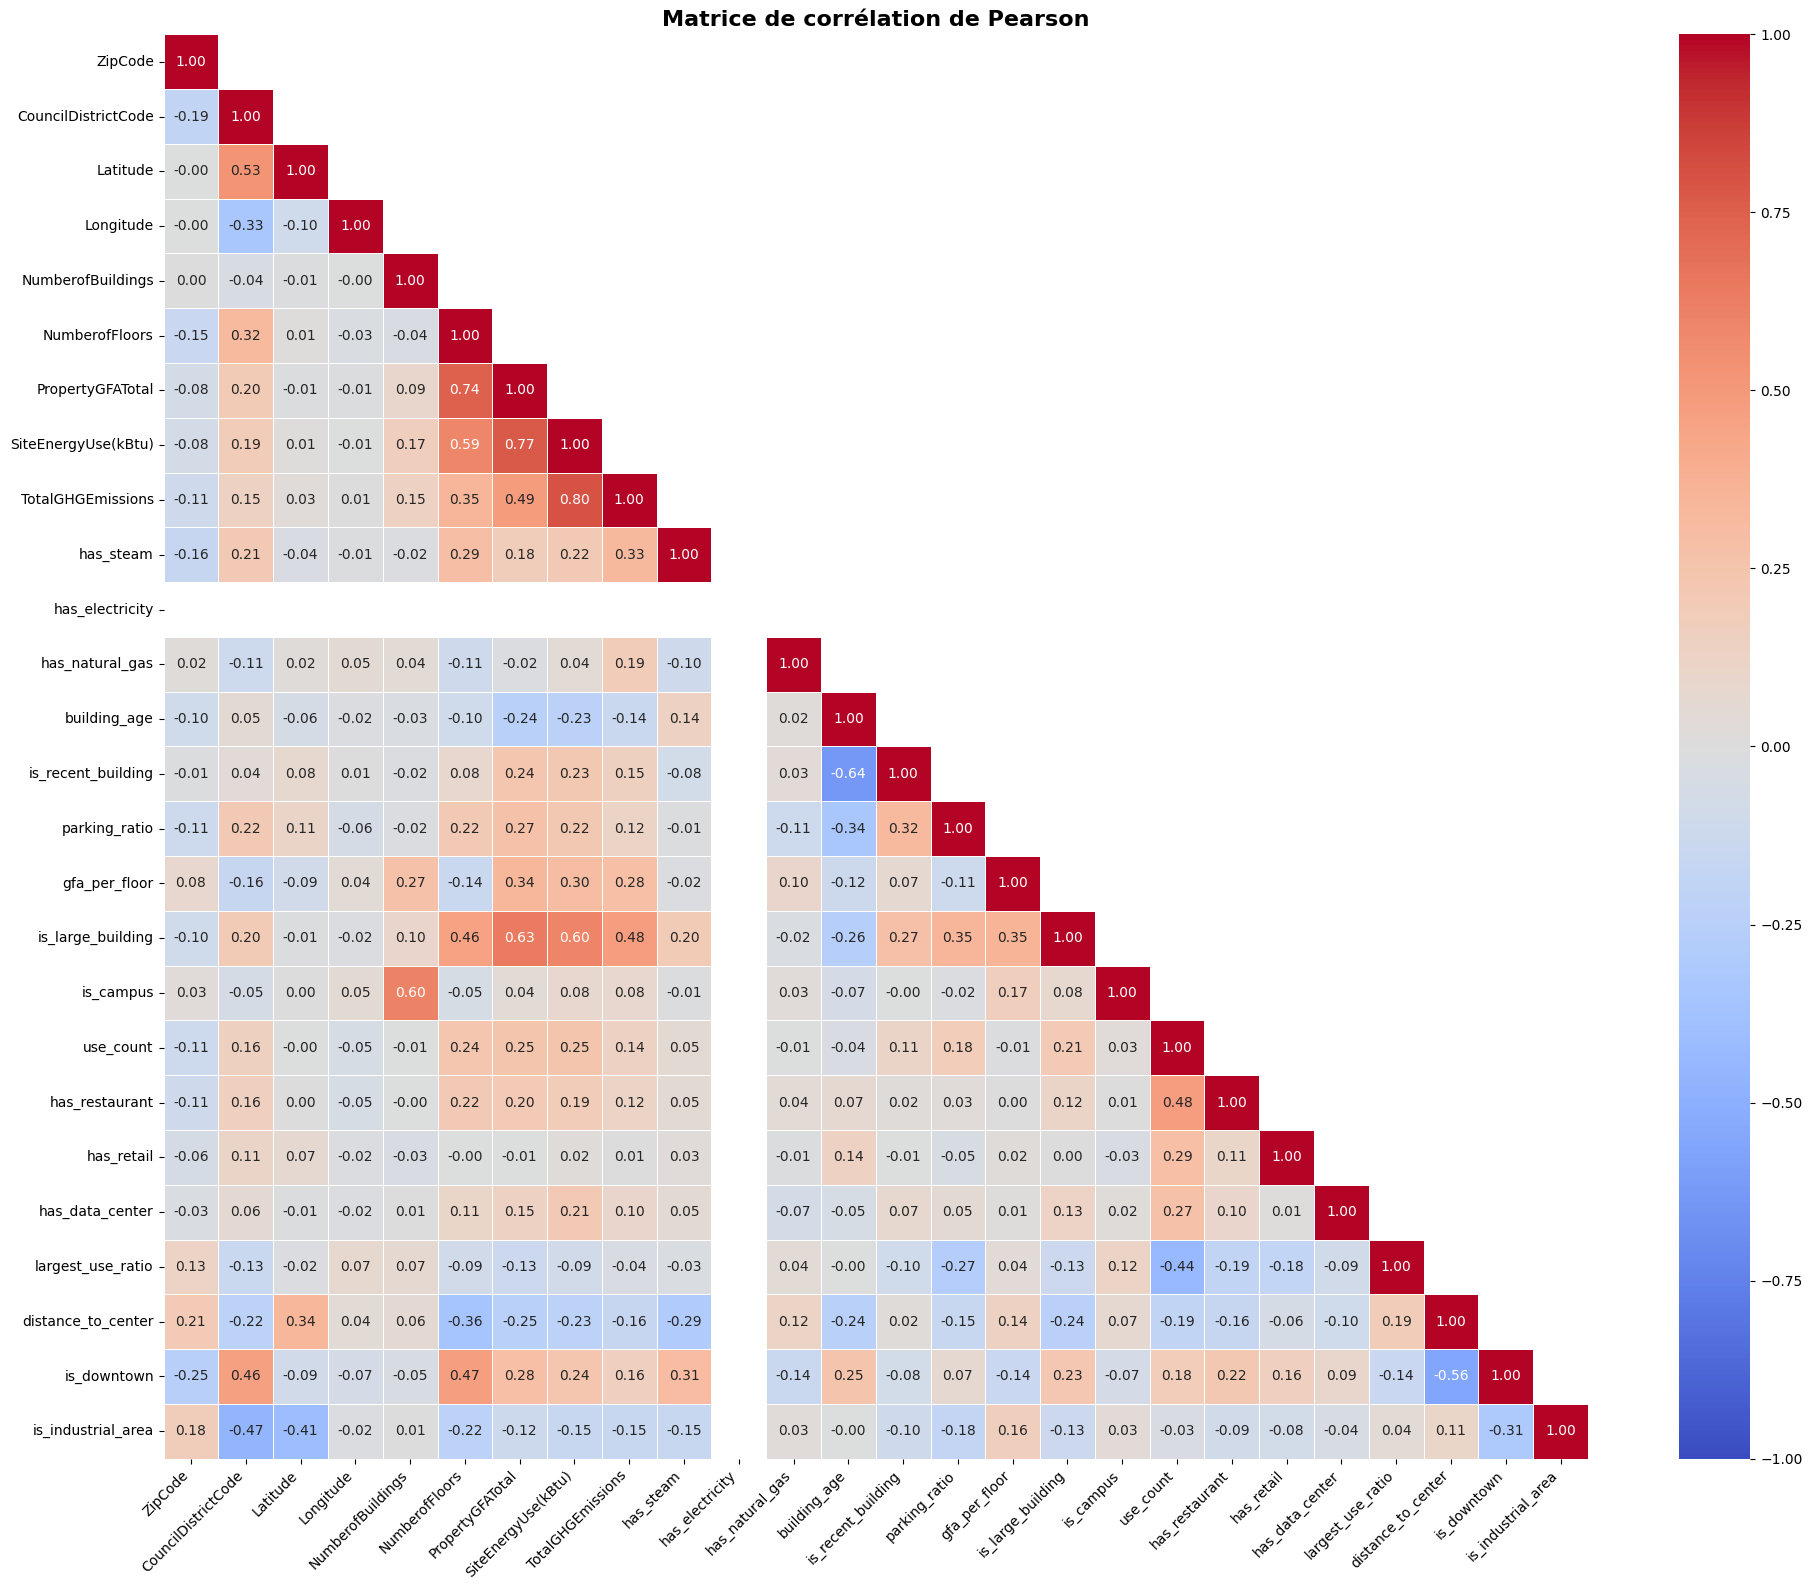

In [55]:
features_redondantes = [
    'YearBuilt',                 # Redondant avec building_age (information équivalente)
    'decade_built',              # Redondant avec building_age (r=1.00)
    'floor_per_building',        # Identique à NumberofFloors (r=1.00)
    'PropertyGFABuilding(s)',    # Redondant avec PropertyGFATotal (r=0.97)
    'PropertyGFAParking',        # Redondant avec PropertyGFATotal (r=0.93-0.97)
    'LargestPropertyUseTypeGFA', # Redondant avec PropertyGFATotal (r=0.95-0.97)+
    'is_multi_energy',           # Redondant avec energy_source_diversity (r=0.93)
    'is_old_building',           # Dérivée de building_age (r=-0.83)
    'is_tall_building',          # Dérivée de NumberofFloors (r=0.79)
	'has_parking',               # Dérivée de parking_ratio (r=0.87)
    'building_ratio',            # Inverse parfait de parking_ratio (r=-1.00)
    'has_multiple_uses',         # Dérivée de use_count (r=0.71)
	'energy_source_diversity'    # Redondant avec has_natural_gas (r= 0.86)
]

df = remove_columns(df, features_redondantes)
heatmap_person(df)

## 5. Analyse des Features Pertinentes pour la Visualisation

#### Types de corrélation et affichages

La corrélation permet de mesurer la relation entre deux variables quantitatives.  
On distingue principalement **trois types de corrélation** :

- **Corrélation positive** : les variables évoluent dans le même sens.  
  Lorsque l’une augmente, l’autre augmente également.  
  → Scatter plot avec une tendance croissante  
  → Coefficient de corrélation proche de **+1**

- **Corrélation négative** : les variables évoluent en sens opposé.  
  Lorsque l’une augmente, l’autre diminue.  
  → Scatter plot avec une tendance décroissante  
  → Coefficient de corrélation proche de **-1**

- **Absence de corrélation** : aucune relation claire entre les variables.  
  Les variations de l’une n’expliquent pas celles de l’autre.  
  → Scatter plot dispersé  
  → Coefficient de corrélation proche de **0**

**Affichage complémentaire :**
- **Heatmap de corrélation** : permet de visualiser rapidement les relations entre plusieurs variables et d’identifier d’éventuelles redondances.


### Scatterplots : Features numériques vs Cibles
**Fichier** : `scatterplots_features_vs_targets.png`

Visualisation de 6 features structurelles importantes vs les 2 cibles :
- `PropertyGFATotal` (Surface totale)
- `NumberofFloors` (Nombre d'étages)
- `buil` (Année de construction)
- `NumberofBuildings` (Nombre de bâtiments)

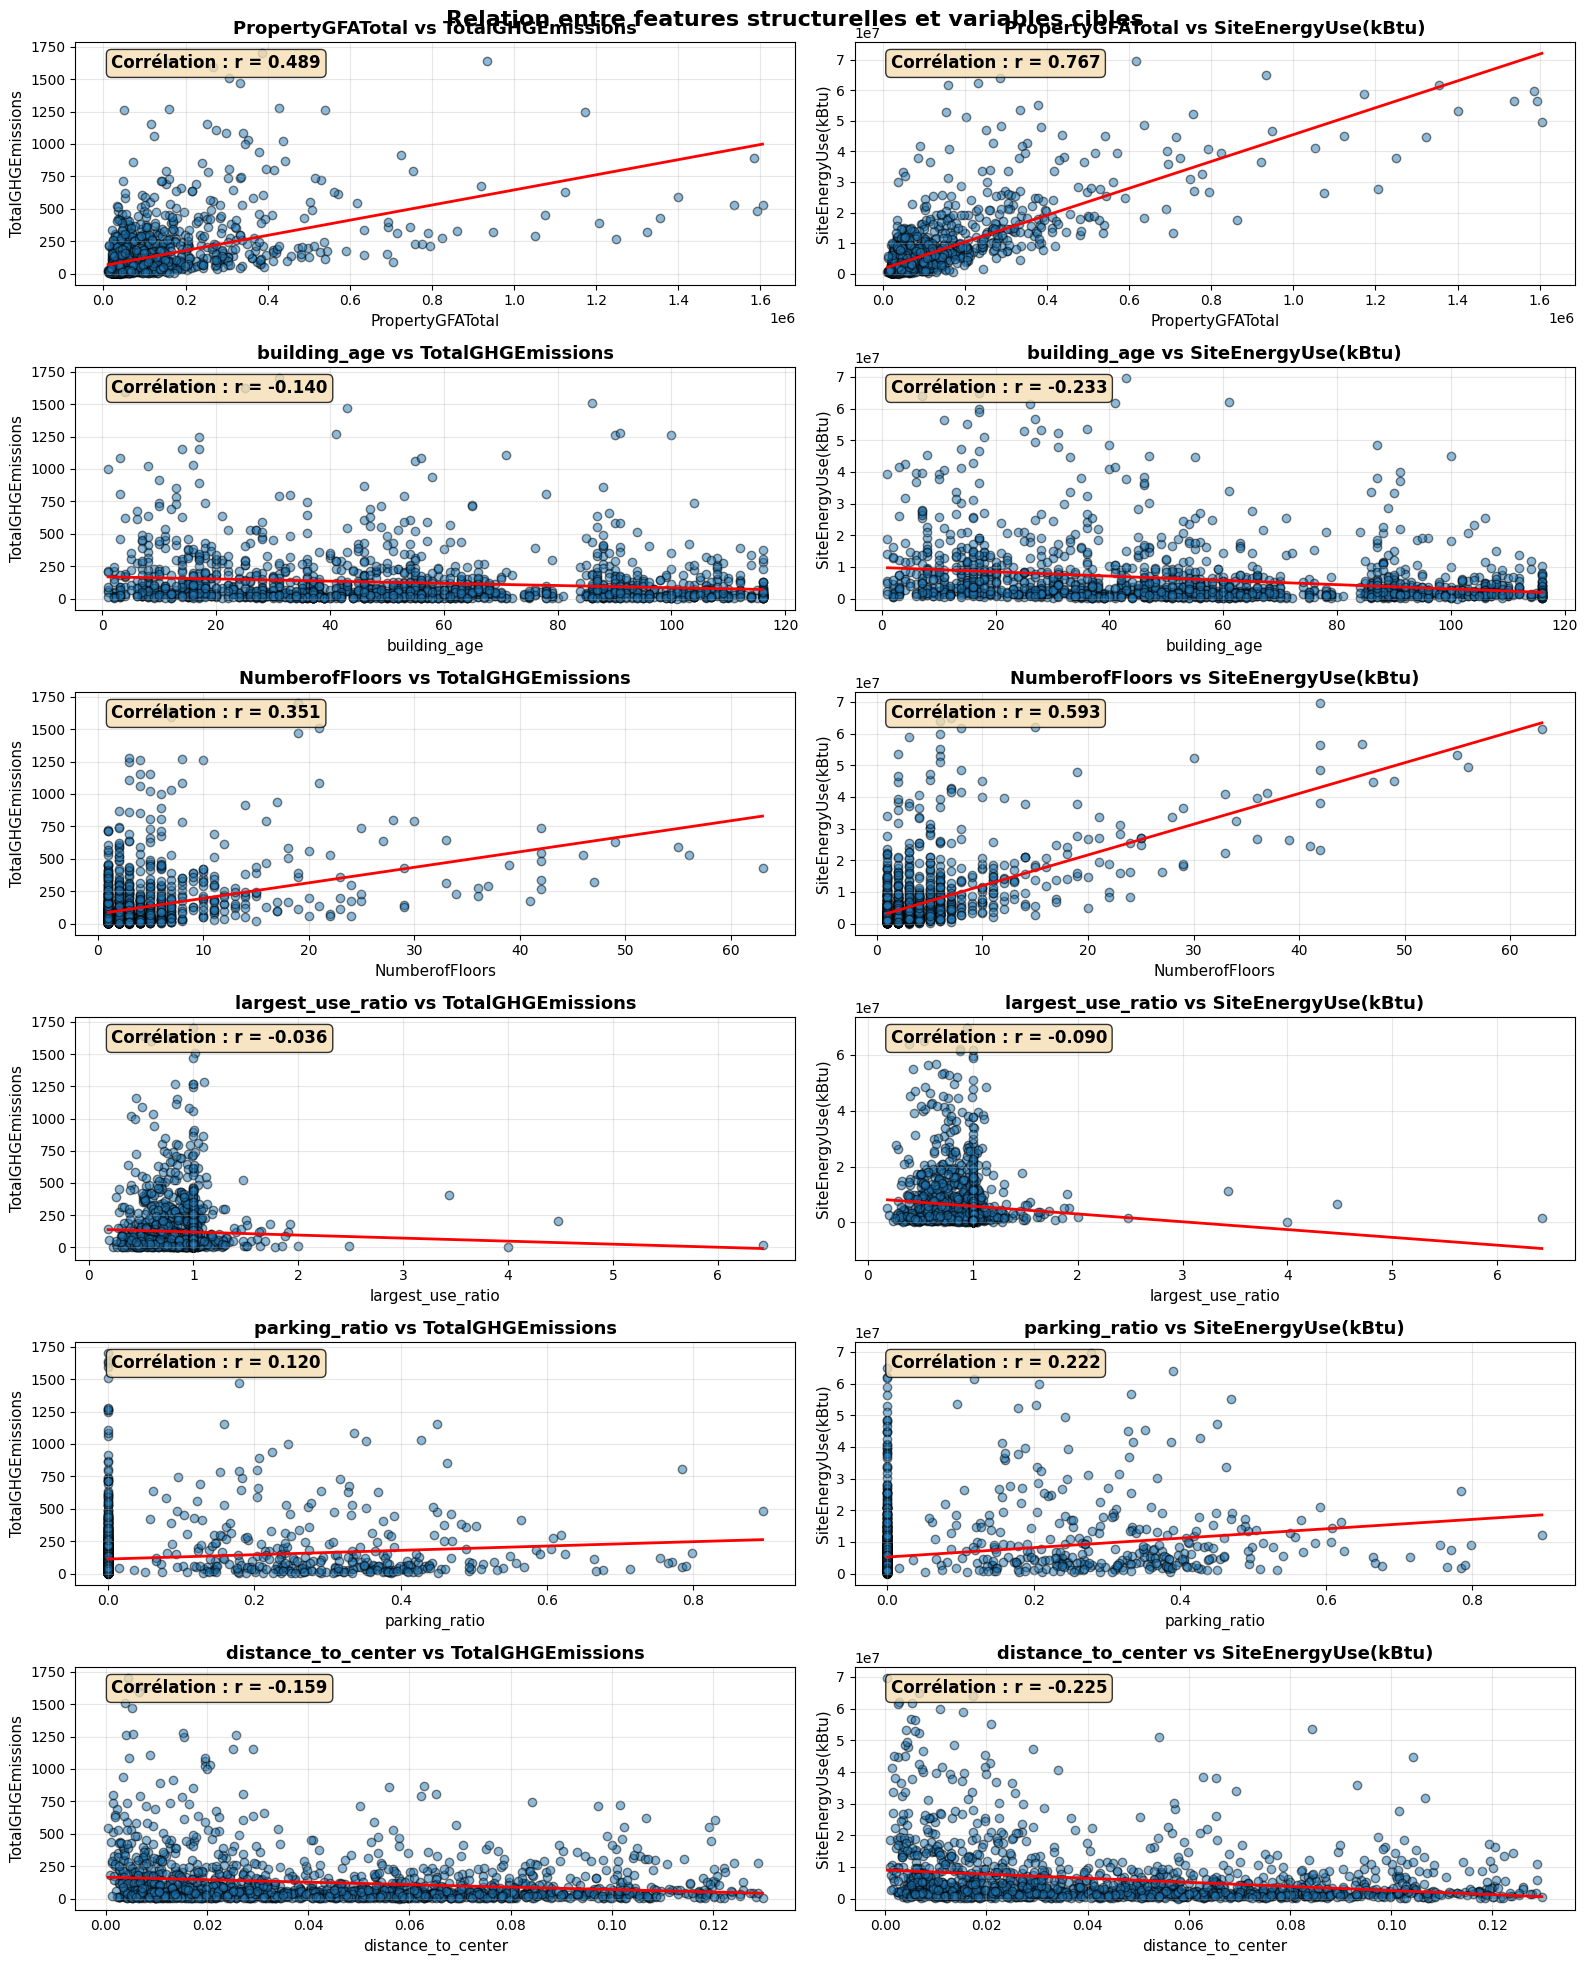

In [56]:
# Sélectionner les features structurelles importantes
features_scatterplot = [
    'PropertyGFATotal',        # Surface totale (corrélation forte attendue)
    'building_age',            # Âge du bâtiment (efficacité énergétique)
    'NumberofFloors',          # Hauteur du bâtiment
    'largest_use_ratio',       # Dominance d'un usage
    'parking_ratio',           # Ratio de parking
    'distance_to_center'       # Distance au centre-ville
]

# features_numeriques = df.select_dtypes(include=[np.number]).columns.tolist()

# Créer une grille de scatterplots
fig, axes = plt.subplots(len(features_scatterplot), 2, figsize=(16, 20))
fig.suptitle('Relation entre features structurelles et variables cibles', 
            fontsize=16, fontweight='bold')

for i, feature in enumerate(features_scatterplot):
    for j, cible in enumerate(CIBLES):
        # Utiliser la fonction create_scatter
        create_scatter(
            df=df,
            var1=feature,
            var2=cible,
            title=f'{feature} vs {cible}',
            xlabel=feature,
            ylabel=cible,
            ax=axes[i, j],
            add_trendline=True,
            add_corr=True
        )

plt.tight_layout()
plt.savefig('graph/scatterplots_features_vs_targets.png', dpi=300, bbox_inches='tight')
plt.show()

**Observations clés** :

- **PropertyGFATotal** :  
  Forte corrélation avec la consommation d’énergie et corrélation modérée avec les émissions de GES. Plus la surface totale du bâtiment est grande, plus il consomme et émet. C’est la variable la plus importante pour un modèle prédictif.

- **Building_age** :  
  Corrélation faible et négative avec l’énergie et les émissions. Les bâtiments récents sont légèrement plus efficaces, mais l’âge seul n’explique pas fortement les performances énergétiques.

- **NumberofFloors** :  
  Corrélation modérée avec la consommation d’énergie et plus faible avec les émissions. Les bâtiments avec plus d’étages consomment généralement plus, souvent parce qu’ils sont plus grands ou plus intensifs.

- **Largest_use_ratio** :  
  Corrélation quasi nulle avec les deux variables cibles. La part du principal usage n’a pas d’impact significatif sur la consommation ou les émissions.

- **Parking_ratio** :  
  Corrélation faible positive avec l’énergie et les émissions. La présence de parkings augmente légèrement la consommation (éclairage, ventilation), mais reste un facteur secondaire.

- **Distance_to_center** :  
  Corrélation faible et négative. Les bâtiments plus éloignés du centre ont tendance à consommer et émettre un peu moins, probablement à cause d’usages moins intensifs.


#### 2. Boxplots : Features catégorielles vs Cibles
Distribution des cibles selon différentes catégories.

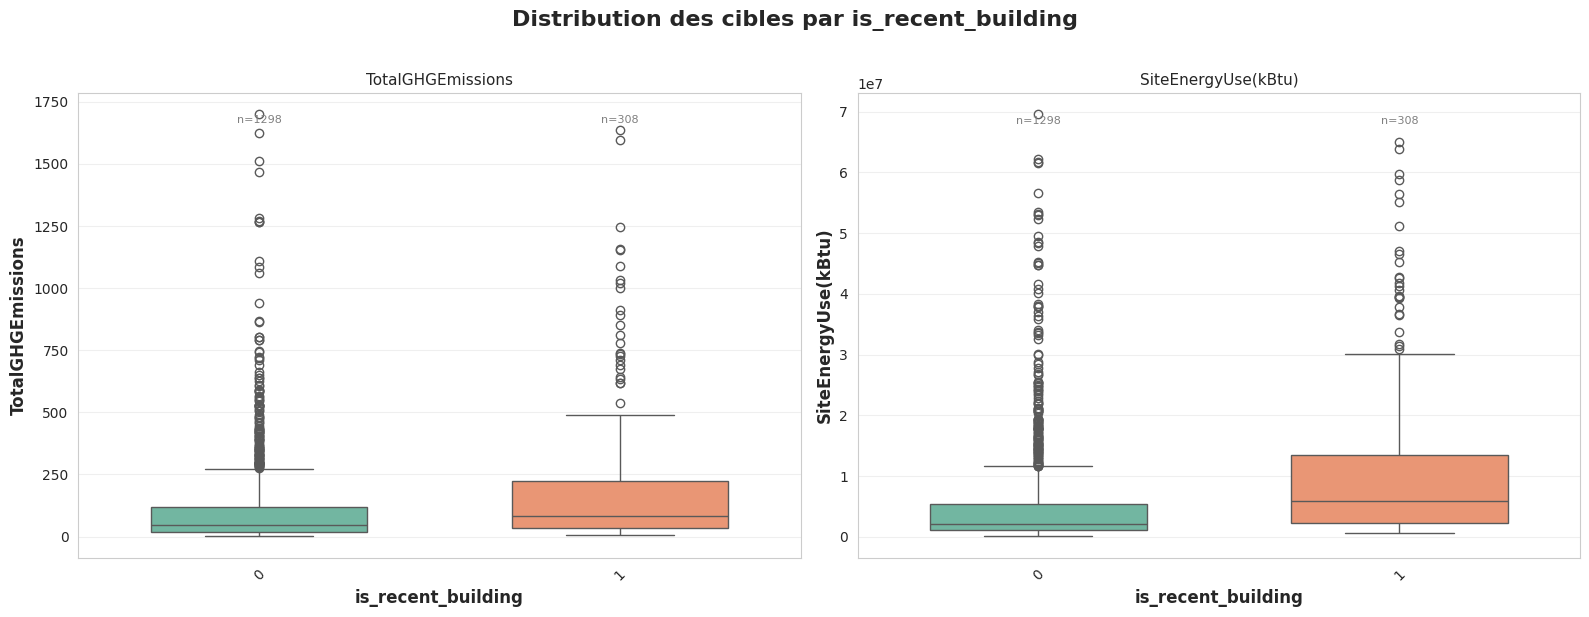

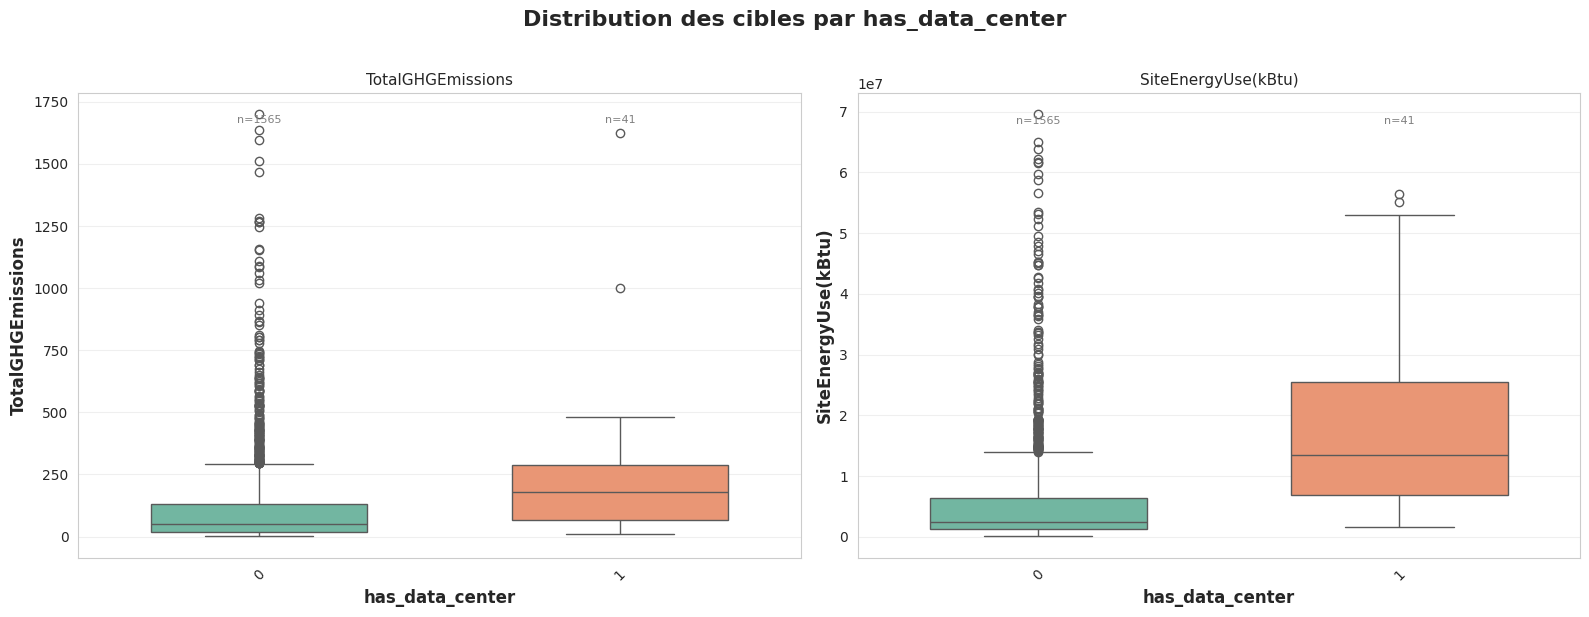

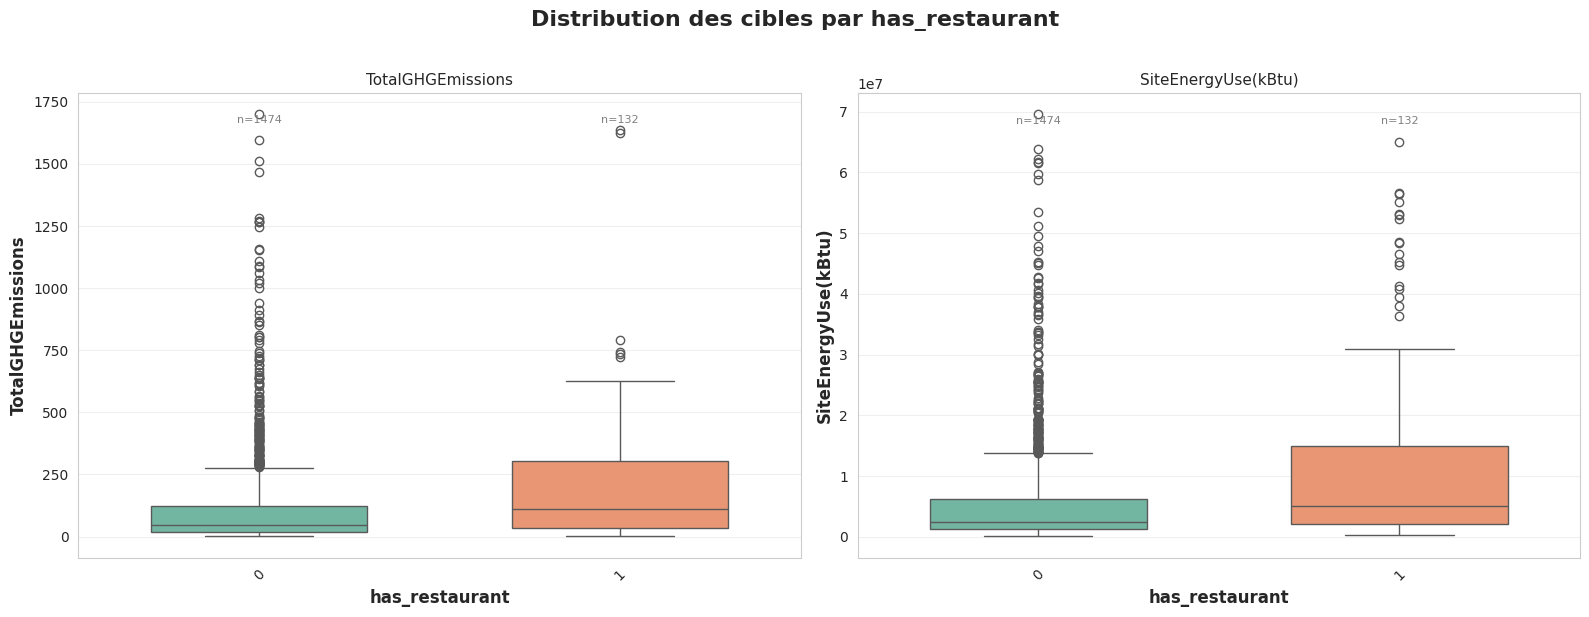

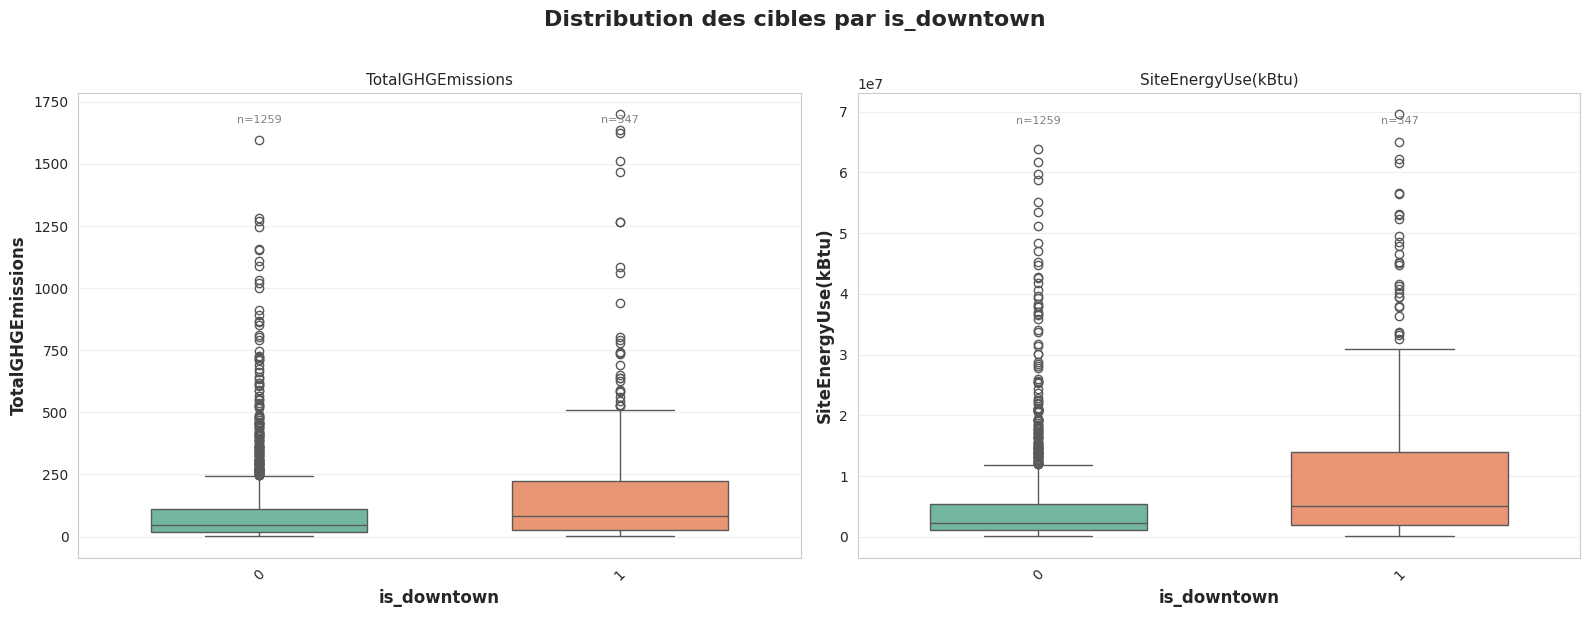

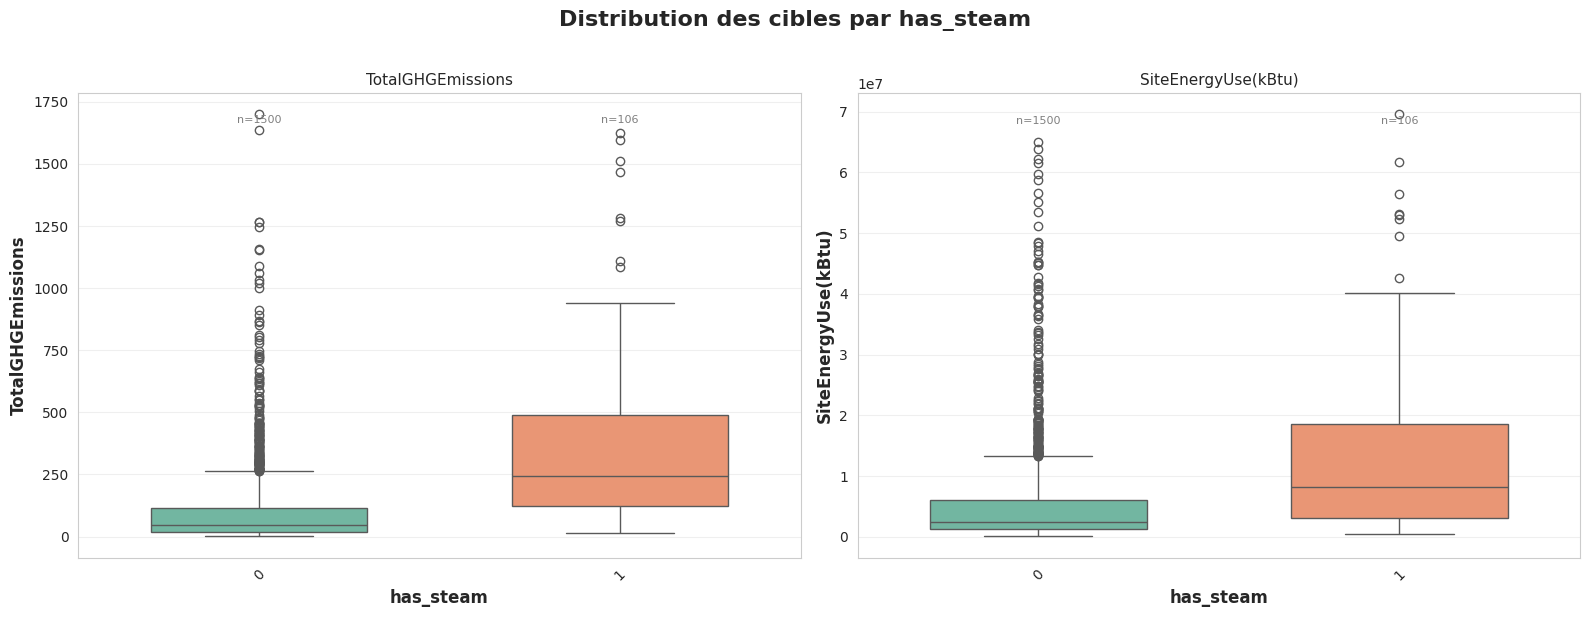

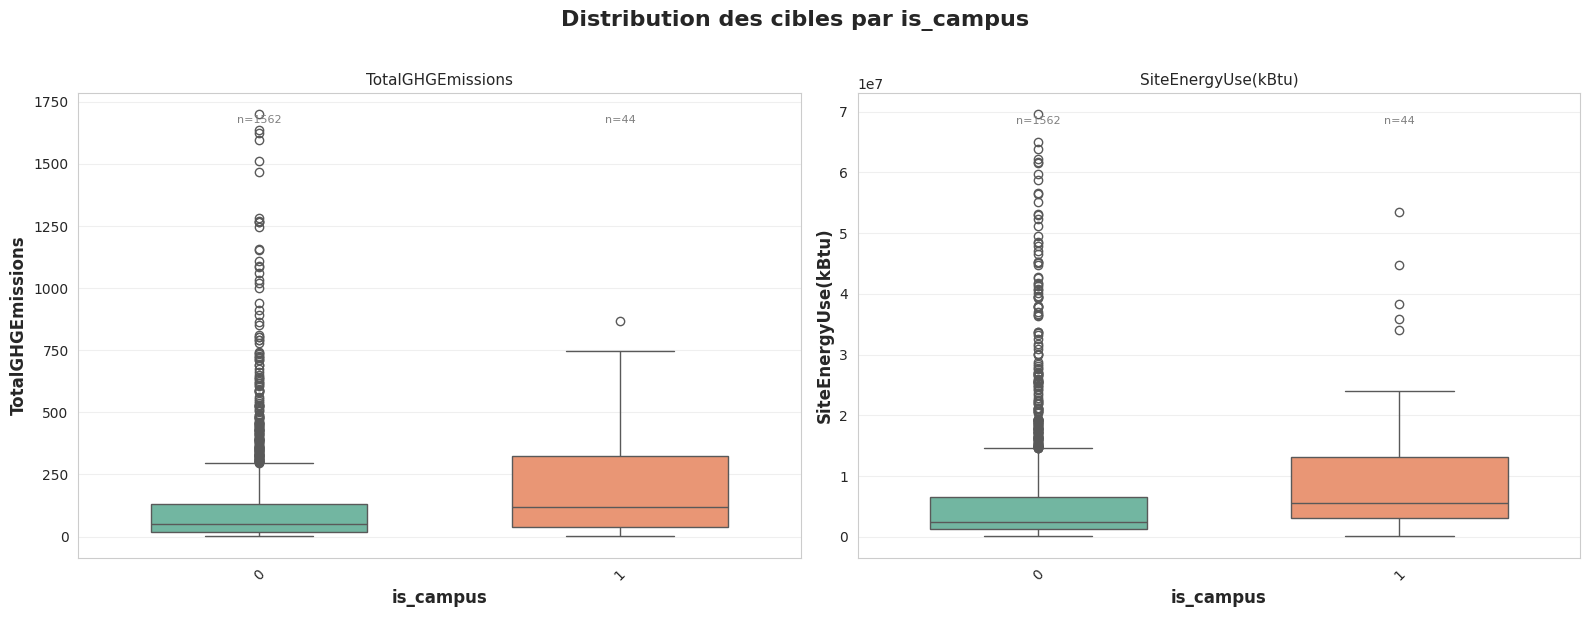

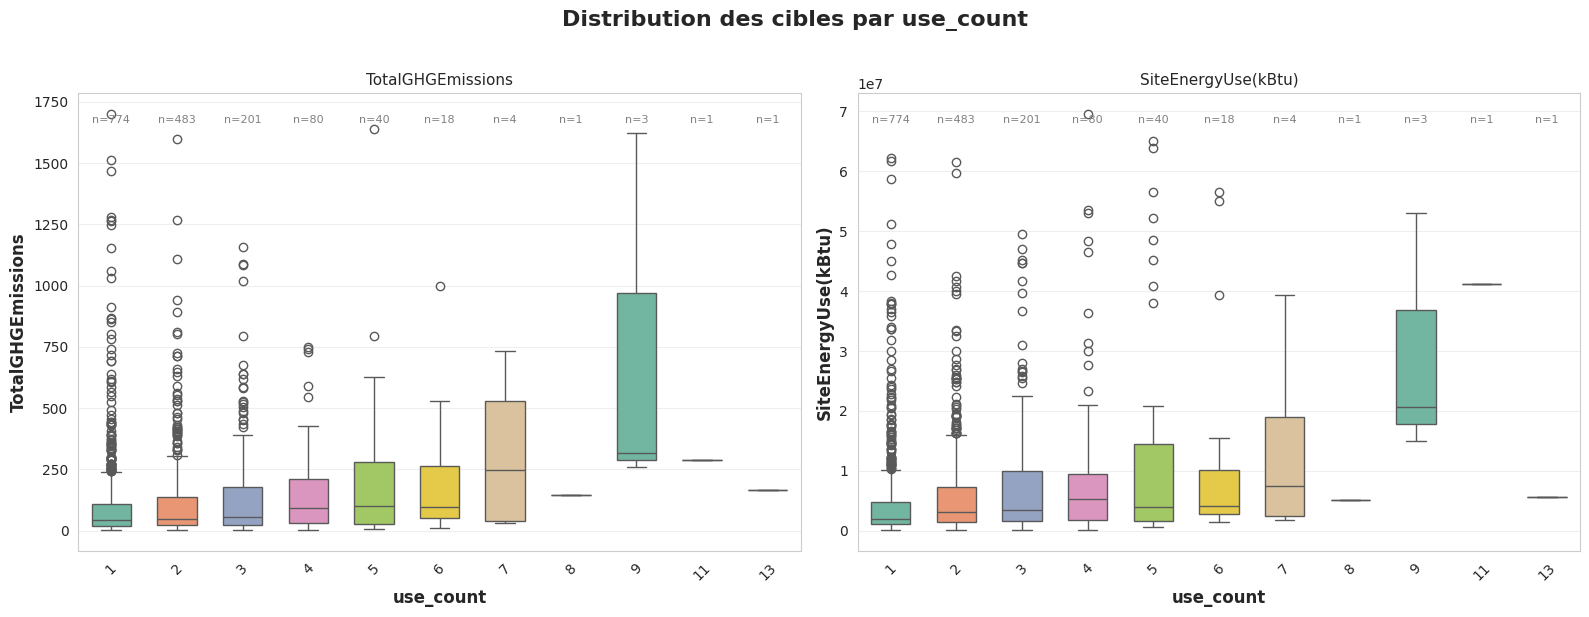

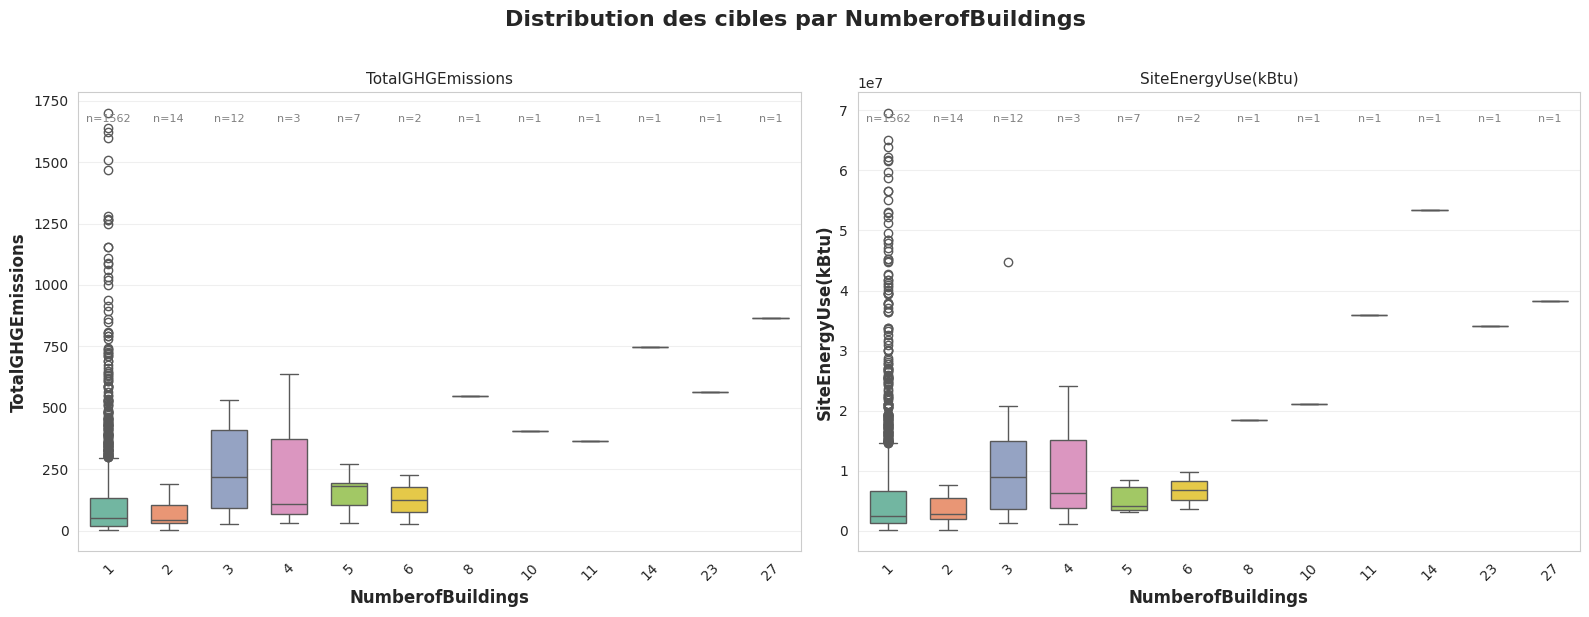

In [57]:
features_boxplot = [
    # Binaires
    'is_recent_building',      # Récent vs ancien (crucial pour 2050)
    'has_data_center',         # Data center (forte consommation)
    'has_restaurant',          # Restaurant (forte consommation)
    'is_downtown',             # Centre-ville vs périphérie
    'has_steam',               # Présence de vapeur
    'is_campus',               # Campus vs bâtiment unique
    
    # Ordinales/Discrètes
    'use_count',               # Nombre d'usages différents
    'NumberofBuildings'        # Nombre de bâtiments (par catégorie)
]

sns.set_style("whitegrid")

for cat_feature in features_boxplot:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Distribution des cibles par {cat_feature}', 
                fontsize=16, fontweight='bold', y=1.02)
    
    # Vérifier le nombre de catégories uniques
    n_unique = df[cat_feature].nunique()
    
    for j, cible in enumerate(CIBLES):
        # Si trop de catégories, garder seulement les top 10 par fréquence
        if n_unique > 15:
            top_cats = df[cat_feature].value_counts().head(10).index
            data_subset = df[df[cat_feature].isin(top_cats)]
            title_suffix = " (Top 10 catégories)"
        else:
            data_subset = df
            title_suffix = ""
        
        # Utiliser seaborn pour de plus beaux boxplots (VERSION CORRIGÉE)
        sns.boxplot(
            data=data_subset, 
            x=cat_feature, 
            y=cible, 
            hue=cat_feature,  # ✅ Ajout de hue pour éviter le warning
            ax=axes[j],
            palette='Set2',
            legend=False,     # ✅ Désactiver la légende (redondant avec x)
            showfliers=True,
            width=0.6
        )
        
        # Personnalisation
        axes[j].set_xlabel(cat_feature, fontsize=12, fontweight='bold')
        axes[j].set_ylabel(cible, fontsize=12, fontweight='bold')
        axes[j].set_title(f'{cible}{title_suffix}', fontsize=11)
        axes[j].tick_params(axis='x', rotation=45, labelsize=10)
        axes[j].tick_params(axis='y', labelsize=10)
        axes[j].grid(axis='y', alpha=0.3)
        
        # Ajouter le nombre d'observations par catégorie
        if n_unique <= 15:
            counts = data_subset.groupby(cat_feature).size()
            for i, (cat, count) in enumerate(counts.items()):
                axes[j].text(i, axes[j].get_ylim()[1] * 0.95, 
                           f'n={count}', 
                           ha='center', va='top', 
                           fontsize=8, color='gray')
    
    plt.tight_layout()
    plt.savefig(f'graph/boxplot_{cat_feature}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

**Observations clés** :

- **is_recent_building** :  
  Les bâtiments récents présentent en moyenne une consommation d’énergie et des émissions de GES plus élevées que les anciens. Cela suggère que l’effet “récent” est probablement confondu avec d’autres facteurs (taille plus grande, usages plus intensifs), plutôt qu’une meilleure efficacité intrinsèque.

- **has_data_center** :  
  Les bâtiments avec un data center consomment beaucoup plus d’énergie et émettent nettement plus de GES. C’est une variable très discriminante, car les data centers sont extrêmement énergivores.

- **has_restaurant** :  
  La présence d’un restaurant est associée à une consommation et des émissions plus élevées. Cela s’explique par des usages spécifiques comme la cuisson, la ventilation et des horaires d’activité étendus.

- **is_downtown** :  
  Les bâtiments situés en centre-ville ont tendance à consommer plus d’énergie et à émettre davantage. Cela reflète souvent des usages plus denses et intensifs (bureaux, commerces).

- **has_steam** :  
  Les bâtiments utilisant la vapeur affichent des niveaux de consommation et d’émissions nettement plus élevés. Cette variable est fortement liée aux émissions de GES et doit être prise en compte dans un modèle.

- **is_campus** :  
  Les bâtiments de type campus présentent en moyenne une consommation et des émissions plus importantes, probablement liées à des surfaces plus grandes et à des usages multiples.

- **use_count** :  
  Le nombre d’usages est globalement associé à une augmentation de l’énergie consommée et des émissions. Les bâtiments multi-usages sont plus complexes et plus énergivores, même si certaines catégories ont peu d’exemples.

- **NumberofBuildings** :  
  Les sites avec plusieurs bâtiments ont tendance à consommer et émettre davantage. Cependant, les effectifs sont faibles pour les valeurs élevées, donc cette variable doit être interprétée avec prudence.

**Conclusion** :  
Les variables binaires et catégorielles liées aux **usages spécifiques** (data center, vapeur, restaurant) sont très informatives. Elles peuvent fortement améliorer un modèle de prédiction, surtout combinées avec les variables de **taille** vues précédemment.


#### Pairplot : Vue d'ensemble
Matrice de scatterplots croisant 5 variables (3 features + 2 cibles) sur un échantillon de 500 bâtiments.

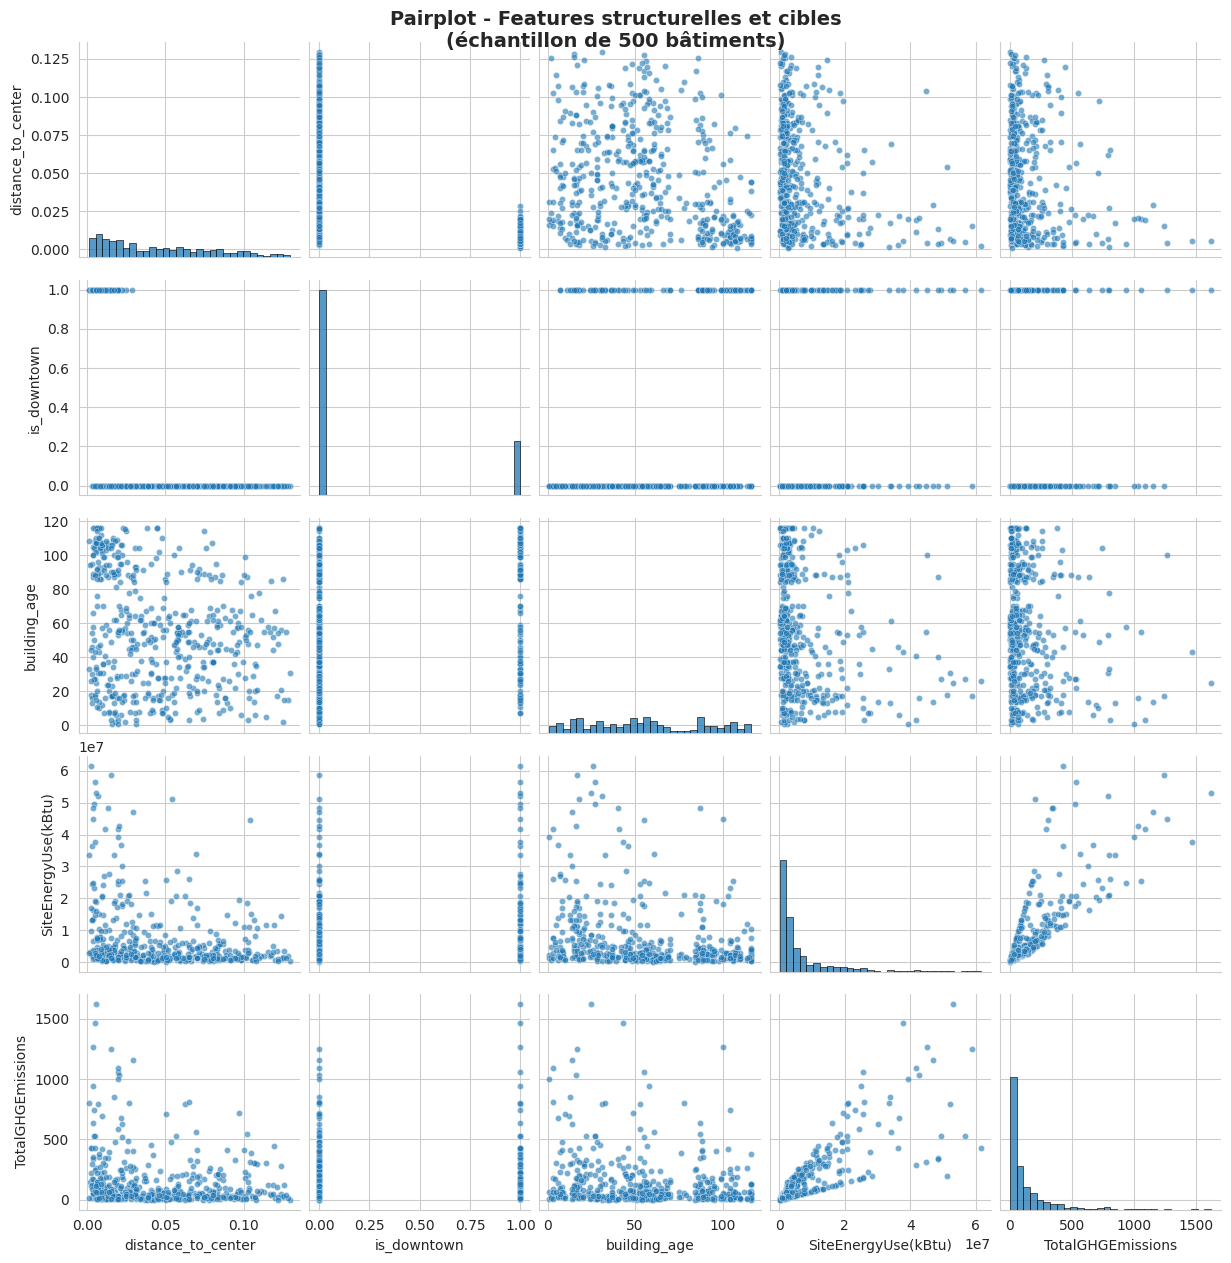

In [58]:
features_pairplot = [
    'distance_to_center',
    'is_downtown',
    'building_age',
    'SiteEnergyUse(kBtu)',
    'TotalGHGEmissions'
]

# Échantillonner pour accélérer (optionnel)
sample_size = min(500, len(df))
df_sample = df[features_pairplot].sample(n=sample_size, random_state=42)

# Créer le pairplot
pairplot = sns.pairplot(df_sample,
                        diag_kind='hist',
                        plot_kws={'alpha': 0.6, 's': 20},
                        diag_kws={'bins': 30, 'edgecolor': 'black'})

pairplot.fig.suptitle('Pairplot - Features structurelles et cibles\n(échantillon de 500 bâtiments)',
                      y=1.01, fontsize=14, fontweight='bold')

plt.savefig('graph/pairplot_features_targets.png', dpi=200, bbox_inches='tight')
plt.show()

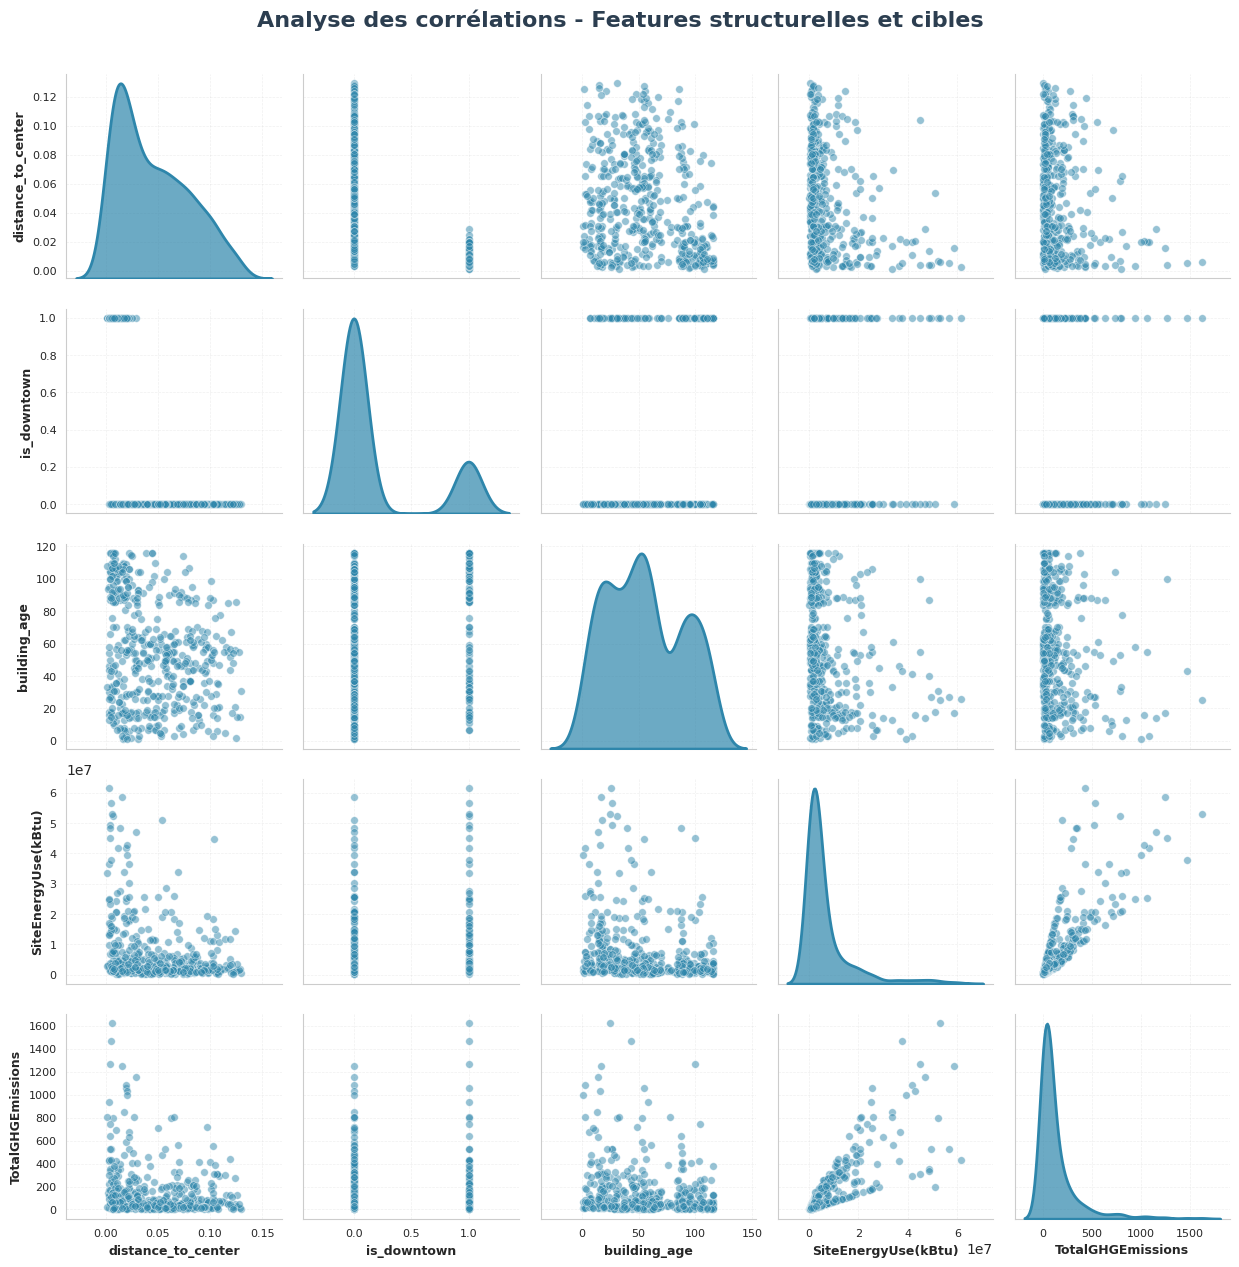

In [59]:
features_pairplot = [
    'distance_to_center',
    'is_downtown',
    'building_age',
    TARGET_ENERGY,
    TARGET_CO2
]

# Échantillonner pour accélérer
sample_size = min(500, len(df))
df_sample = df[features_pairplot].sample(n=sample_size, random_state=42)

# Définir une palette de couleurs moderne
palette = sns.color_palette("husl", n_colors=len(features_pairplot))

# Créer le pairplot avec style amélioré
sns.set_style("whitegrid")
pairplot = sns.pairplot(
    df_sample,
    diag_kind='kde',
    plot_kws={
        'alpha': 0.5,
        's': 30,
        'edgecolor': 'white',
        'linewidth': 0.5,
        'color': '#2E86AB'
    },
    diag_kws={
        'color': '#2E86AB',
        'alpha': 0.7,
        'linewidth': 2
    },
    corner=False
)

# Améliorer les labels des axes
pairplot.fig.suptitle(
    'Analyse des corrélations - Features structurelles et cibles',
    y=1.01,
    fontsize=16,
    fontweight='bold',
    color='#2C3E50'
)

# Personnaliser chaque subplot
for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=9, fontweight='semibold')
    ax.set_ylabel(ax.get_ylabel(), fontsize=9, fontweight='semibold')
    ax.tick_params(labelsize=8)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('graph/pairplot_features_targets.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Réinitialiser le style pour ne pas affecter les autres graphiques
sns.reset_defaults()

**Observations clés** :

- **SiteEnergyUse (kBtu) ↔ TotalGHGEmissions** :  
  Relation **forte et positive**. Plus un bâtiment consomme d’énergie, plus il émet de GES. C’est une relation logique et centrale, confirmant que la consommation énergétique est un excellent prédicteur des émissions.

- **Building_age** :  
  Aucune relation claire avec la consommation d’énergie ni avec les émissions. On observe une forte dispersion, ce qui montre que l’âge du bâtiment seul n’explique pas bien la performance énergétique (rénovations, usages, équipements jouent un rôle).

- **Distance_to_center** :  
  Tendance **faible et négative** avec l’énergie et les émissions. Les bâtiments proches du centre ont souvent des valeurs plus élevées, mais la relation reste peu marquée.

- **is_downtown** :  
  Les bâtiments situés en centre-ville présentent globalement des niveaux plus élevés de consommation et d’émissions. Cette variable agit surtout comme un **indicateur de contexte urbain** (densité, intensité d’usage).

- **Distribution des cibles** :  
  - *SiteEnergyUse* et *TotalGHGEmissions* sont **très asymétriques (skewed)**, avec beaucoup de petites valeurs et quelques valeurs très élevées.  
  - Cela suggère qu’une **transformation logarithmique** peut être utile avant la modélisation.

**Conclusion** :  
Les graphiques confirment que la **consommation d’énergie est la variable clé** pour expliquer les émissions. Les variables structurelles et contextuelles (âge, centre-ville, distance) apportent surtout des informations complémentaires.


### Carte géographique (heatmap interactive)


🗺️  Génération des cartes géographiques...


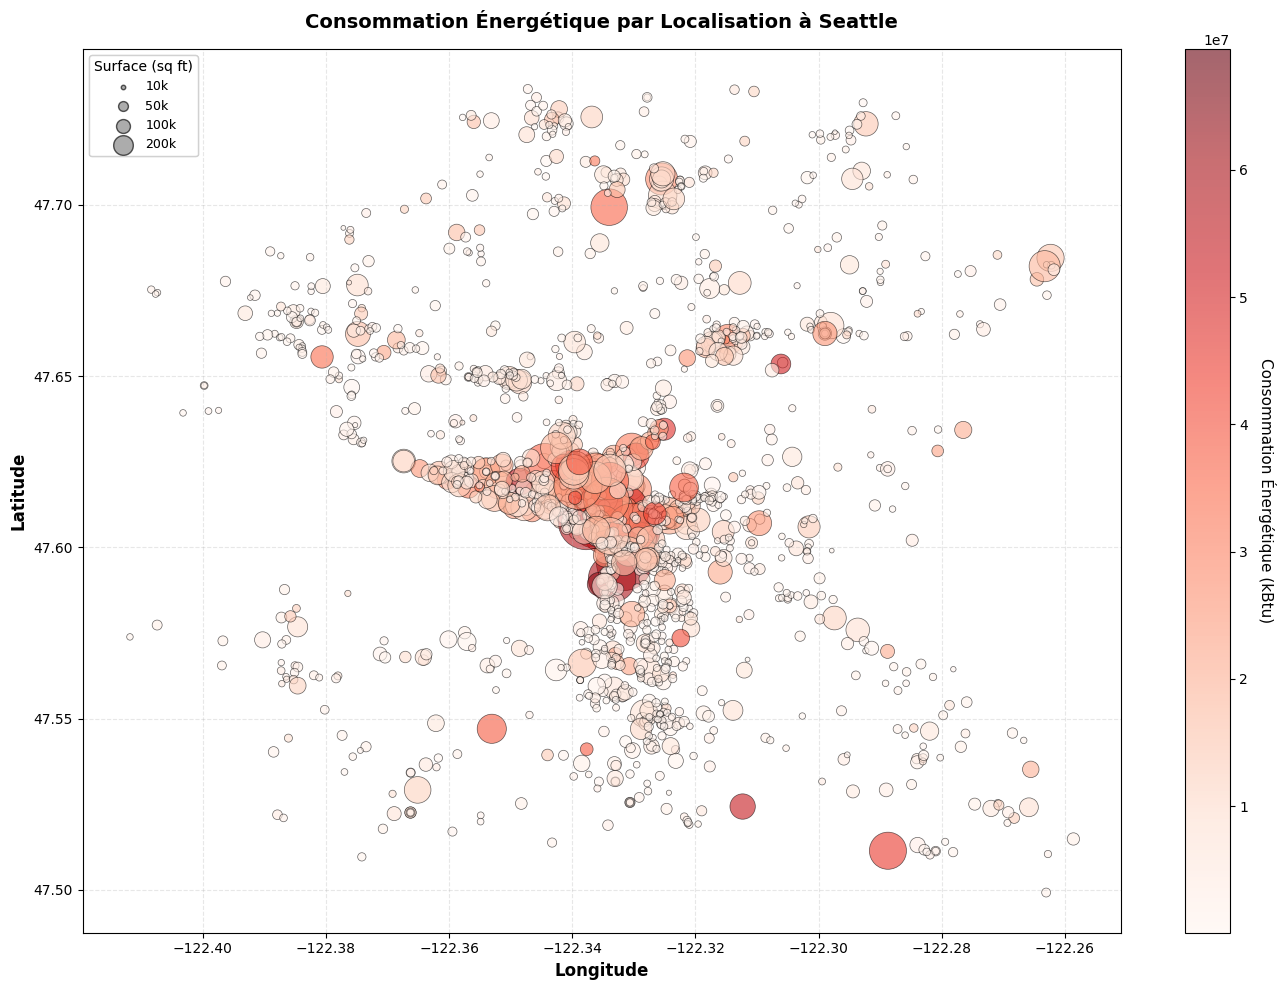

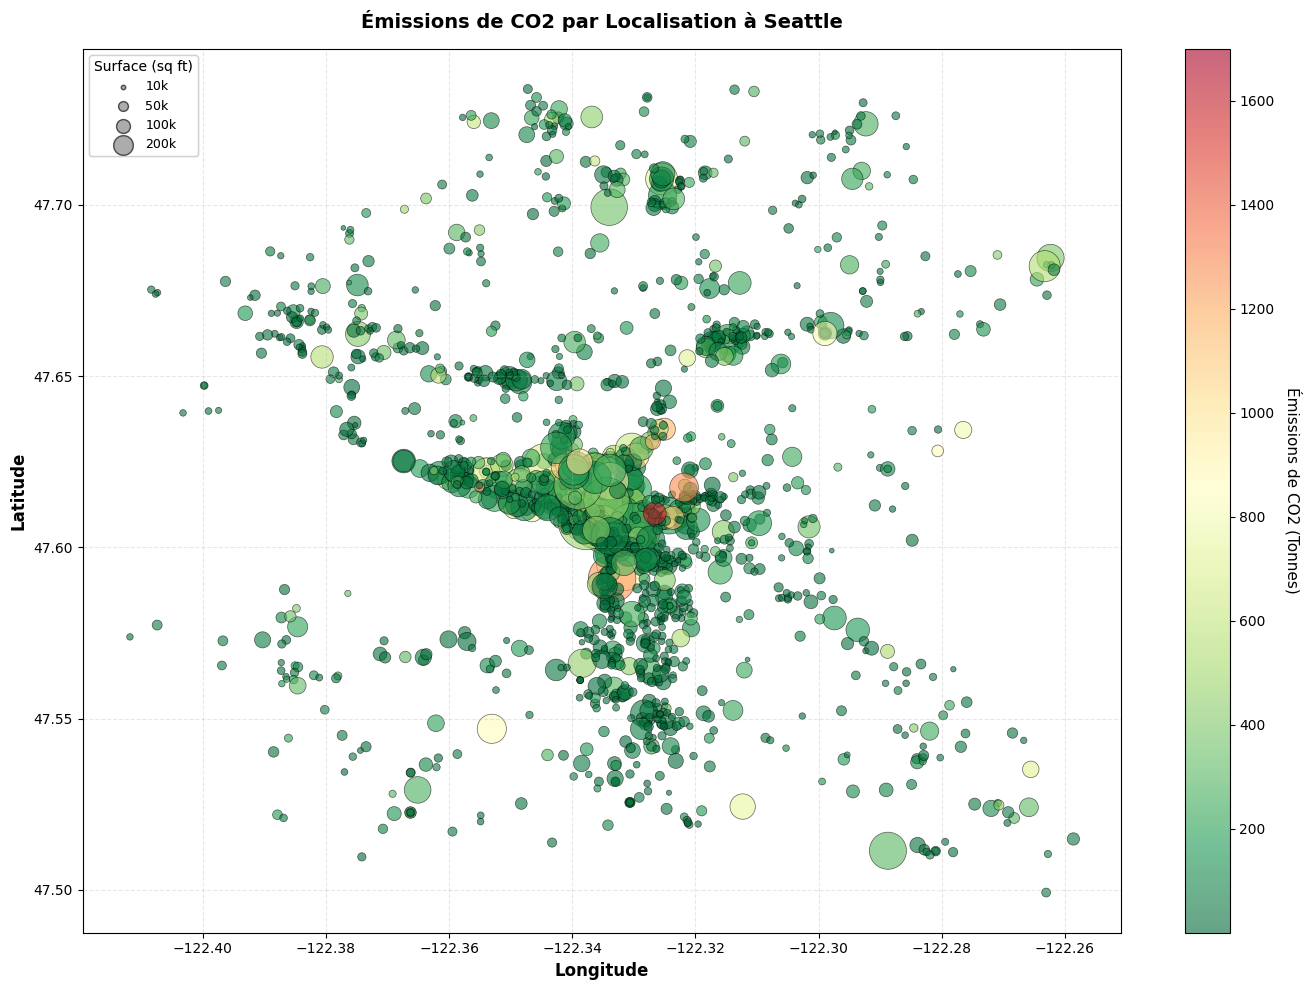

In [60]:
print("\n🗺️  Génération des cartes géographiques...")

# Carte 1 : Consommation énergétique
fig, ax = plt.subplots(figsize=(14, 10))

scatter = ax.scatter(
    df['Longitude'],
    df['Latitude'],
    c=df['SiteEnergyUse(kBtu)'],
    s=df['PropertyGFATotal'] / 1000,  # Taille proportionnelle à la surface
    cmap='Reds',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

# Colorbar pour la consommation
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Consommation Énergétique (kBtu)', rotation=270, labelpad=20, fontsize=11)

ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax.set_title('Consommation Énergétique par Localisation à Seattle', 
             fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle='--')

# Ajouter une légende pour la taille des points
sizes = [10000, 50000, 100000, 200000]
labels = ['10k', '50k', '100k', '200k']
legend_elements = [plt.scatter([], [], s=s/1000, c='gray', alpha=0.6, edgecolors='black') 
                   for s in sizes]
legend1 = ax.legend(legend_elements, labels, 
                    title='Surface (sq ft)', 
                    loc='upper left', 
                    frameon=True, 
                    fontsize=9,
                    title_fontsize=10)
ax.add_artist(legend1)

plt.tight_layout()
plt.savefig('graph/carte_consommation_energie.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Carte 2 : Émissions de CO2
fig, ax = plt.subplots(figsize=(14, 10))

scatter = ax.scatter(
    df['Longitude'],
    df['Latitude'],
    c=df['TotalGHGEmissions'],
    s=df['PropertyGFATotal'] / 1000,
    cmap='RdYlGn_r',  # Rouge = élevé, Vert = faible
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

# Colorbar pour les émissions
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Émissions de CO2 (Tonnes)', rotation=270, labelpad=20, fontsize=11)

ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax.set_title('Émissions de CO2 par Localisation à Seattle', 
             fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle='--')

# Légende pour la taille
legend_elements = [plt.scatter([], [], s=s/1000, c='gray', alpha=0.6, edgecolors='black') 
                   for s in sizes]
legend1 = ax.legend(legend_elements, labels, 
                    title='Surface (sq ft)', 
                    loc='upper left', 
                    frameon=True, 
                    fontsize=9,
                    title_fontsize=10)
ax.add_artist(legend1)

plt.tight_layout()
plt.savefig('graph/carte_emissions_co2.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

**Observations clés** :

- **Concentration spatiale (centre de Seattle)** :  
  La consommation énergétique et les émissions de CO₂ sont fortement concentrées au centre-ville. Cette zone regroupe les bâtiments les plus énergivores et les plus émetteurs, ce qui reflète une forte densité urbaine et des usages intensifs.

- **Relation surface – énergie – émissions** :  
  Les plus gros cercles (bâtiments de grande surface) correspondent majoritairement aux niveaux les plus élevés de consommation et d’émissions. La surface du bâtiment reste donc un facteur structurant, même à l’échelle spatiale.

- **Dispersion en périphérie** :  
  En dehors du centre, les bâtiments sont plus dispersés et présentent en général des niveaux plus faibles d’énergie consommée et d’émissions, avec quelques points atypiques (outliers).

- **Similarité des patterns énergie / CO₂** :  
  Les cartes de consommation énergétique et d’émissions montrent des distributions très similaires. Cela confirme que les émissions de CO₂ sont fortement dépendantes de la consommation d’énergie.

- **Présence d’outliers spatiaux** :  
  Certains bâtiments isolés affichent des valeurs très élevées en énergie ou en émissions. Ils correspondent probablement à des usages spécifiques (data centers, hôpitaux, grands complexes).

**Conclusion** :  
La localisation apporte une information contextuelle importante, surtout pour distinguer le centre-ville de la périphérie.

#### Analyse par âge du bâtiment


📈 Statistiques descriptives par tranche d'âge :



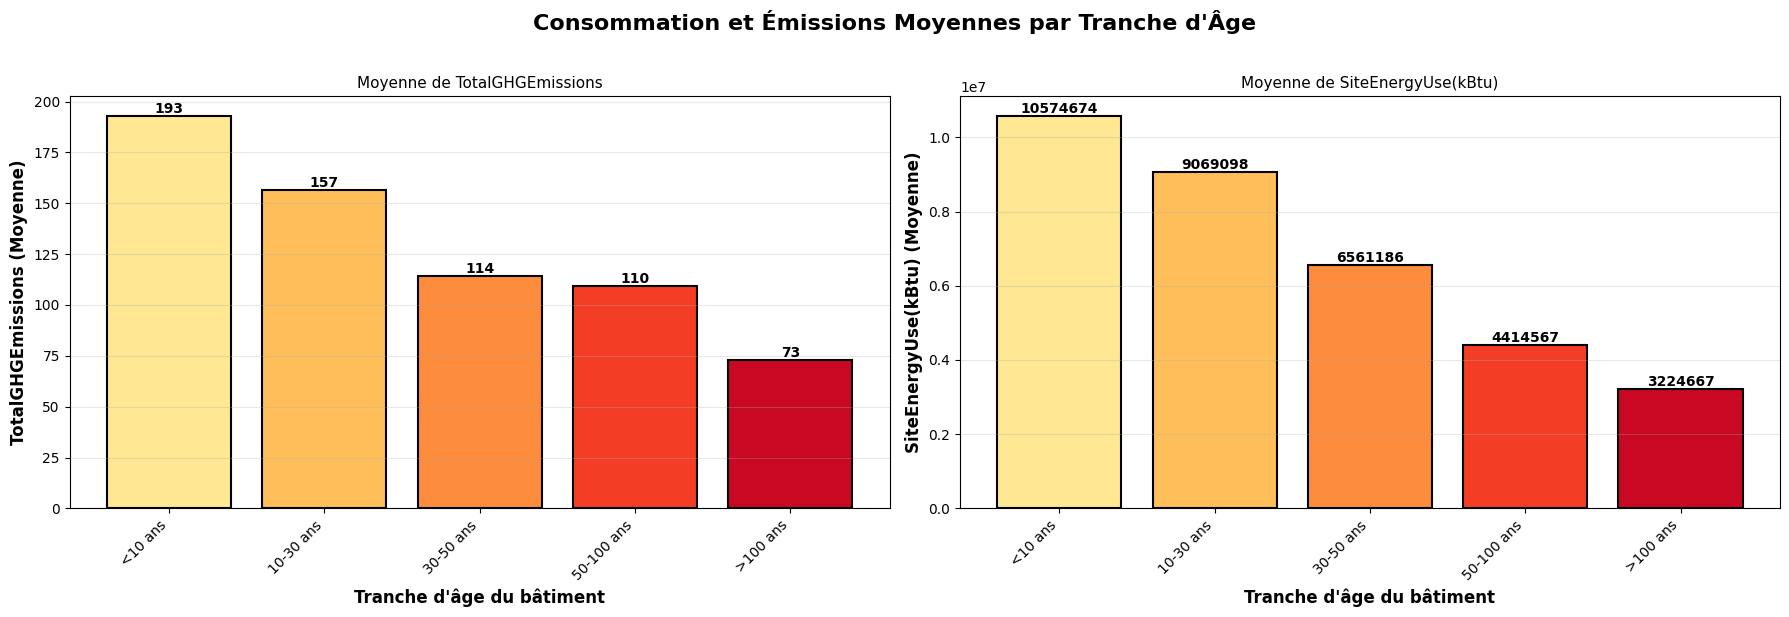

In [61]:
print("\n📈 Statistiques descriptives par tranche d'âge :\n")

# Définir les bins et labels
age_bins = [0, 10, 30, 50, 100, 150]
age_labels = ['<10 ans', '10-30 ans', '30-50 ans', '50-100 ans', '>100 ans']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Consommation et Émissions Moyennes par Tranche d\'Âge', 
             fontsize=16, fontweight='bold', y=1.02)

for j, cible in enumerate(CIBLES):
    # Utiliser pd.cut directement dans groupby avec observed=True
    mean_by_age = df.groupby(
        pd.cut(df['building_age'], 
               bins=age_bins, 
               labels=age_labels, 
               include_lowest=True),
        observed=True  # ← Ajout de ce paramètre
    )[cible].mean().sort_index()
    
    bars = axes[j].bar(
        range(len(mean_by_age)),
        mean_by_age.values,
        color=sns.color_palette('YlOrRd', len(mean_by_age)),
        edgecolor='black',
        linewidth=1.5
    )
    
    axes[j].set_xticks(range(len(mean_by_age)))
    axes[j].set_xticklabels(mean_by_age.index, rotation=45, ha='right')
    axes[j].set_xlabel('Tranche d\'âge du bâtiment', fontsize=12, fontweight='bold')
    axes[j].set_ylabel(f'{cible} (Moyenne)', fontsize=12, fontweight='bold')
    axes[j].set_title(f'Moyenne de {cible}', fontsize=11)
    axes[j].grid(axis='y', alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for i, (bar, value) in enumerate(zip(bars, mean_by_age.values)):
        axes[j].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                   f'{value:.0f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('graph/barplot_age_moyenne.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

**Observations clés** :

- **Tendance générale avec l’âge** :  
  On observe une **diminution progressive** de la consommation énergétique moyenne et des émissions de GES lorsque l’âge du bâtiment augmente.

- **Bâtiments récents (< 10 ans)** :  
  Ce sont ceux qui présentent les **valeurs moyennes les plus élevées** en consommation d’énergie et en émissions. Cela indique que les bâtiments récents ne sont pas forcément plus sobres, probablement à cause de surfaces plus grandes ou d’usages plus intensifs.

- **Bâtiments de 10 à 30 ans** :  
  Les niveaux restent élevés mais commencent à diminuer, ce qui suggère un compromis entre taille, usage et efficacité.

- **Bâtiments de 30 à 100 ans** :  
  La consommation et les émissions sont nettement plus faibles en moyenne. Ces bâtiments sont souvent plus petits ou ont des usages moins énergivores.

- **Bâtiments très anciens (> 100 ans)** :  
  Ils affichent les **niveaux moyens les plus bas**. Cela peut s’expliquer par des surfaces réduites, des usages spécifiques ou des rénovations ciblées.

**Conclusion** :  
L’âge du bâtiment a un effet indirect sur la consommation et les émissions. En réalité, il reflète surtout d’autres caractéristiques comme la taille ou le type d’usage du bâtiment. L’âge est donc utile, mais il doit être utilisé avec d’autres variables pour éviter de mauvaises interprétations.

### Graphiques supplémentaires

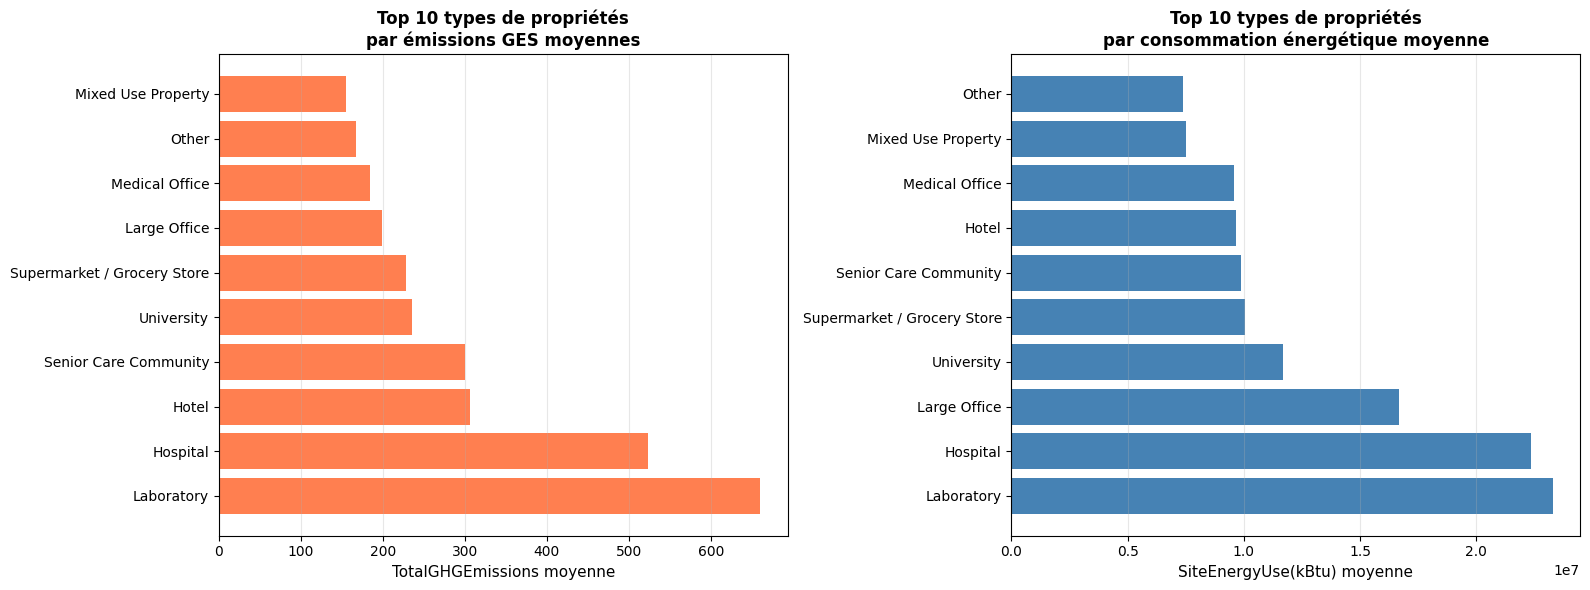

In [62]:
# 4.1 Top types de propriétés par émissions/consommation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Émissions moyennes par type
property_ghg = df.groupby('PrimaryPropertyType')['TotalGHGEmissions'].mean().sort_values(ascending=False).head(10)
axes[0].barh(range(len(property_ghg)), property_ghg.values, color='coral')
axes[0].set_yticks(range(len(property_ghg)))
axes[0].set_yticklabels(property_ghg.index, fontsize=10)
axes[0].set_xlabel('TotalGHGEmissions moyenne', fontsize=11)
axes[0].set_title('Top 10 types de propriétés\npar émissions GES moyennes', 
                 fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Consommation moyenne par type
property_energy = df.groupby('PrimaryPropertyType')['SiteEnergyUse(kBtu)'].mean().sort_values(ascending=False).head(10)
axes[1].barh(range(len(property_energy)), property_energy.values, color='steelblue')
axes[1].set_yticks(range(len(property_energy)))
axes[1].set_yticklabels(property_energy.index, fontsize=10)
axes[1].set_xlabel('SiteEnergyUse(kBtu) moyenne', fontsize=11)
axes[1].set_title('Top 10 types de propriétés\npar consommation énergétique moyenne',
                 fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('graph/top_property_types.png', dpi=300, bbox_inches='tight')
plt.show()


## 6. Insights principaux

In [63]:
print("\n" + "="*80)
print("RÉSUMÉ DES OBSERVATIONS")
print("="*80)

# Calculer les corrélations
numeric_features = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in CIBLES]

print("\nTop 5 features corrélées avec TotalGHGEmissions :")
corr_ghg = df[numeric_features + ['TotalGHGEmissions']].corr()['TotalGHGEmissions'].sort_values(ascending=False)[1:6]
for i, (feat, corr) in enumerate(corr_ghg.items(), 1):
    print(f"  {i}. {feat}: {corr:.3f}")

print("\nTop 5 features corrélées avec SiteEnergyUse(kBtu) :")
corr_energy = df[numeric_features + ['SiteEnergyUse(kBtu)']].corr()['SiteEnergyUse(kBtu)'].sort_values(ascending=False)[1:6]
for i, (feat, corr) in enumerate(corr_energy.items(), 1):
    print(f"  {i}. {feat}: {corr:.3f}")


RÉSUMÉ DES OBSERVATIONS

Top 5 features corrélées avec TotalGHGEmissions :
  1. PropertyGFATotal: 0.489
  2. is_large_building: 0.480
  3. NumberofFloors: 0.351
  4. has_steam: 0.327
  5. gfa_per_floor: 0.282

Top 5 features corrélées avec SiteEnergyUse(kBtu) :
  1. PropertyGFATotal: 0.767
  2. is_large_building: 0.597
  3. NumberofFloors: 0.593
  4. gfa_per_floor: 0.302
  5. use_count: 0.247


## 8. Composition finale de X et y

In [64]:
# Séparer X et y
X = df.drop(columns=CIBLES)
y = df[CIBLES]

print(f"X : {X.shape}")
print(f"y : {y.shape}")

X : (1606, 34)
y : (1606, 2)


## 9. Encodage des variables catégorielles

**Objectif** :

Transformer les variables catégorielles en variables numériques pour que les algorithmes de Machine Learning puissent les utiliser.


In [65]:
# Identifier les features catégorielles et numériques
X_categorical = X.select_dtypes(include=['object']).columns.tolist()
X_numeric = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nDimensions de X AVANT encodage : {X.shape}")
print(f"  • Features numériques : {len(X_numeric)}")
print(f"  • Features catégorielles : {len(X_categorical)}")

print(X_categorical)


Dimensions de X AVANT encodage : (1606, 34)
  • Features numériques : 24
  • Features catégorielles : 4
['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'building_age_bucket']


In [66]:
def display_columns_info(df: pd.DataFrame, columns: List[str]):
    for col in columns:
        n_unique = df[col].nunique()
        n_missing = df[col].isna().sum()
        pct_unique = (n_unique / len(df)) * 100
        pct_missing = (n_missing / len(df)) * 100
        
        print(f"• {col}:")
        print(f"  - Type : {df[col].dtype}")
        print(f"  - Valeurs uniques: {n_unique} ({pct_unique:.1f}%)")
        print(f"  - Valeurs manquantes: {n_missing} ({pct_missing:.1f}%)")
        
        # Afficher les valeurs si peu nombreuses
        if n_unique <= 10:
            print(f"  - Valeurs: {df[col].unique()}")
        print("")
 
display_columns_info(df, X_categorical)

• BuildingType:
  - Type : object
  - Valeurs uniques: 5 (0.3%)
  - Valeurs manquantes: 0 (0.0%)
  - Valeurs: ['NonResidential' 'Nonresidential COS' 'SPS-District K-12' 'Campus'
 'Nonresidential WA']

• PrimaryPropertyType:
  - Type : object
  - Valeurs uniques: 22 (1.4%)
  - Valeurs manquantes: 0 (0.0%)

• Neighborhood:
  - Type : object
  - Valeurs uniques: 13 (0.8%)
  - Valeurs manquantes: 0 (0.0%)

• building_age_bucket:
  - Type : object
  - Valeurs uniques: 3 (0.2%)
  - Valeurs manquantes: 0 (0.0%)
  - Valeurs: ['old' 'recent' 'intermediate']



### Stratégie d'encodage pour votre dataset

| Feature | Modalités | Type | Encodage recommandé | Raison |
|---------|-----------|------|---------------------|--------|
| `building_age_bucket` | 3 | **Ordinale** |  | Ordre naturel clair (old < intermediate < recent) |
| `BuildingType` | 5 | Nominale | **OneHotEncoder** | Peu de modalités, pas d'ordre naturel |
| `Neighborhood` | 13 | Nominale | **OneHotEncoder** | Cardinalité raisonnable |
| `PrimaryPropertyType` | 22 | Nominale | **OneHotEncoder** | Limite acceptable mais surveiller |

In [67]:
from sklearn.preprocessing import OneHotEncoder

# Features ordinal à encoder
age_mapping = {'old': 0, 'intermediate': 1, 'recent': 2}
X['building_age_bucket'] = X['building_age_bucket'].map(age_mapping)

# # Features nominales à encoder
# nominal_features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

# # Créer et appliquer l'encoder
# encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
# X_encoded = encoder.fit_transform(X[nominal_features])

# # Récupérer les noms et créer un DataFrame
# feature_names = encoder.get_feature_names_out(nominal_features)
# X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names, index=X.index)

# # Remplacer les colonnes originales
# X = X.drop(columns=nominal_features)
# X = pd.concat([X, X_encoded_df], axis=1)

### Vérifications de l'encodage

In [68]:
remaining_categorical = X.select_dtypes(include=['object']).columns.tolist()

if len(remaining_categorical) > 0:
    print(f"⚠️ Il reste {len(remaining_categorical)} features catégorielles :")
    print(remaining_categorical)
else:
    print("✅ Toutes les features sont numériques !")

⚠️ Il reste 3 features catégorielles :
['BuildingType', 'PrimaryPropertyType', 'Neighborhood']


In [69]:
print(f"Shape de X : {X.shape}")
print(f"Features numériques : {len(X.select_dtypes(include=[np.number]).columns)}")

Shape de X : (1606, 34)
Features numériques : 25


In [70]:
print(X.dtypes.value_counts())

int64      19
float64     6
bool        6
object      3
Name: count, dtype: int64


In [71]:
print(f"Valeurs manquantes : {X.isna().sum().sum()}")

Valeurs manquantes : 0


In [72]:
print("\n" + "="*80)
print("💾 SAUVEGARDE DU DATASET")
print("="*80)

# Sauvegarder le dataset
output_path = 'data/data_modelisation.csv'
df_final = pd.concat([X, y], axis=1)
df_final.to_csv(output_path, index=False)

print(f"\n✅ Dataset sauvegardé : {output_path}")
print(f"   Shape : {df_final.shape}")
print(f"   Taille : {df_final.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


💾 SAUVEGARDE DU DATASET

✅ Dataset sauvegardé : data/data_modelisation.csv
   Shape : (1606, 36)
   Taille : 0.64 MB


## 10. Synthèse de la préparation des données

### Pipeline de transformation

| Étape | Dataset avant | Dataset après | Modifications |
|-------|---------------|---------------|---------------|
| 📥 **Chargement** | - | (1630, 65) | Dataset brut issue du feature engineering |
| 🧹 **Suppression colonnes** | (1630, 65) | (1630, 43) | -22 colonnes (métadonnées + colonnes redondantes) |
| 🎯 **Suppression outliers** | (1630, 43) | (1606, 43) | -24 bâtiments (1.5%) via Z-score seuil=2 |
| 🔢 **Séparation X/y** | (1606, 43) | X: (1606, 34), y: (1606, 2) | Target = `SiteEnergyUse(kBtu)` et `TotalGHGEmissions` |
| 🏷️ **Encodage** | X: (1606, 34) | X: (1606, 68) | +34 features (OHE sur 4 variables catégorielles) |
| 💾 **Dataset final** | - | **(1606, 70)** | **68 features + 2 targets** |

### Caractéristiques du dataset final

**Target** : `SiteEnergyUse(kBtu)` et `TotalGHGEmissions`
- Observations : 1,606 bâtiments
- Outliers supprimés : 24 (1.5%)
- Distribution : asymétrique avec queue étendue vers les valeurs élevées

**Features** : 68 variables explicatives
- Numériques continues : 24 (ex: Latitude, Longitude, PropertyGFATotal, building_age, distance_to_center...)
- Numériques discrètes : 6 (ex: ZipCode, CouncilDistrictCode, NumberofBuildings, NumberofFloors, use_count...)  
- Booléennes : 32 (variables "has_*", "is_*" + encodages OHE)
- Valeurs manquantes : 0 (après imputation)

**Encodages appliqués** :
- `building_age_bucket` : LabelEncoder (ordinal : old=0, intermediate=1, recent=2)
- `BuildingType` : OneHotEncoder (5 modalités → 4 features)
- `PrimaryPropertyType` : OneHotEncoder (22 modalités → 21 features)
- `Neighborhood` : OneHotEncoder (13 modalités → 12 features)

### Insights clés pour la modélisation

**Features les plus corrélées avec SiteEnergyUse(kBtu)** :
1. `PropertyGFATotal`: 0.767
2. `is_large_building`: 0.597
3. `NumberofFloors`: 0.593
4. `gfa_per_floor`: 0.302
5. `use_count`: 0.247

**Features les plus corrélées avec TotalGHGEmissions** :
1. `PropertyGFATotal`: 0.489
2. `is_large_building`: 0.480
3. `NumberofFloors`: 0.351
4. `has_steam`: 0.327
5. `gfa_per_floor`: 0.282

**Features faiblement corrélées** :
- Variables géographiques : `Latitude`, `Longitude`, `distance_to_center`
- Variables de localisation : `Neighborhood_*`, `ZipCode`
- Certaines variables booléennes spécifiques : `has_restaurant`, `has_retail`, `has_data_center`


# Comparaison de différents modèles supervisés

In [73]:
from sklearn.pipeline import Pipeline

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

### Préparation du pipeline de preprocessing

In [74]:
# Séparer les features numériques et catégorielles
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Features numériques ({len(numerical_features)}) : {numerical_features}")
print(f"Features catégorielles ({len(categorical_features)}) : {categorical_features}")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
         categorical_features)
    ])

print("Preprocessor créé avec succès")

Features numériques (25) : ['ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'has_steam', 'has_electricity', 'has_natural_gas', 'building_age', 'building_age_bucket', 'is_recent_building', 'parking_ratio', 'gfa_per_floor', 'is_large_building', 'is_campus', 'use_count', 'has_restaurant', 'has_retail', 'has_data_center', 'largest_use_ratio', 'distance_to_center', 'is_downtown', 'is_industrial_area']
Features catégorielles (3) : ['BuildingType', 'PrimaryPropertyType', 'Neighborhood']
Preprocessor créé avec succès


## Séparation des données
**Objectif** : Créer un jeu d'entraînement (train) et un jeu de test

In [75]:
y = df[TARGET_ENERGY]

# Séparation train/test (80/20 classique)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42
)

# Affichage des dimensions
print("\n" + "="*50)
print("🔀 SÉPARATION TRAIN / TEST")
print("="*50)
print(f"X_train : {X_train.shape} ({X_train.shape[0]} lignes)")
print(f"y_train : {y_train.shape}")
print("\n")
print(f"X_test  : {X_test.shape} ({X_test.shape[0]} lignes)")
print(f"y_test  : {y_test.shape}")

# Vérifier la répartition
print(f"\nProportion train : {len(X_train) / len(X) * 100:.1f}%")
print(f"Proportion test  : {len(X_test) / len(X) * 100:.1f}%")


🔀 SÉPARATION TRAIN / TEST
X_train : (1284, 34) (1284 lignes)
y_train : (1284,)


X_test  : (322, 34) (322 lignes)
y_test  : (322,)

Proportion train : 80.0%
Proportion test  : 20.0%


## Modèles de régression – scikit-learn

### DummyRegressor
- Modèle de référence (baseline)
- Ne prend pas en compte les variables explicatives
- Prédit une valeur simple (moyenne, médiane, constante, aléatoire)
- Sert à comparer les performances des autres modèles

### LinearRegression
- Modèle de régression linéaire
- Suppose une relation linéaire entre les variables et la cible
- Simple, rapide et interprétable
- Limité pour des relations complexes ou non linéaires

### SVR (Support Vector Regressor)
- Basé sur les machines à vecteurs de support
- Tolère une erreur ε autour de la prédiction
- Permet des relations non linéaires via les kernels
- Sensible aux hyperparamètres et coûteux en calcul

### RandomForestRegressor
- Ensemble d’arbres de décision
- Capture des relations non linéaires complexes
- Robuste au bruit et aux valeurs aberrantes
- Moins interprétable et plus gourmand en ressources

### Résumé
- DummyRegressor : modèle de référence
- LinearRegression : simple et explicable
- SVR : puissant sur données non linéaires
- RandomForestRegressor : performant sur problèmes complexes


In [76]:
def evaluate_model_cv(model, X, y, model_name, cv=5):
    """
    Évalue un modèle avec validation croisée.
    
    Parameters:
    -----------
    model : Pipeline sklearn
        Le modèle à évaluer
    X, y : données d'entraînement
    model_name : str
        Nom du modèle pour l'affichage
    cv : int
        Nombre de folds pour la cross-validation
    
    Returns:
    --------
    dict : résultats de la cross-validation
    """
    scoring = {
        "r2": "r2",
        "mae": "neg_mean_absolute_error",
        "rmse": "neg_root_mean_squared_error"
    }

    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )

    results = {
        "model_name": model_name,
        'r2_train_mean': cv_results['train_r2'].mean(),
        'r2_train_std': cv_results['train_r2'].std(),
        'r2_test_mean': cv_results['test_r2'].mean(),
        'r2_test_std': cv_results['test_r2'].std(),
        'mae_test_mean': -cv_results['test_mae'].mean(),
        'mae_test_std': cv_results['test_mae'].std(),
        'rmse_test_mean': -cv_results['test_rmse'].mean(),
        'rmse_test_std': cv_results['test_rmse'].std(),
    }

    # Calculer l'écart train/test pour détecter l'overfit
    results['ecart_r2'] = results['r2_train_mean'] - results['r2_test_mean']
    
    return results

In [77]:
pipelines = {
    "Dummy": Pipeline([
        ("preprocessor", preprocessor),
        ("model", DummyRegressor(strategy="mean"))
    ]),
    "LinearRegression": Pipeline([
        ("preprocessor", preprocessor),
        ("model", LinearRegression())
    ]),

    "SVR": Pipeline([
        ("preprocessor", preprocessor),
        ("model", SVR())
    ]),

    "RandomForest": Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(random_state=42))
    ])
}

all_results = []

for name, pipe in pipelines.items():
    print(f"\nModèle en cours : {name}")
    baseline_results = evaluate_model_cv(
        pipe, X_train, y_train, name, cv=5
    )
    all_results.append(baseline_results)



Modèle en cours : Dummy


/home/rapha/ai-engineer/projet-3/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/rapha/ai-engineer/projet-3/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)



Modèle en cours : LinearRegression


/home/rapha/ai-engineer/projet-3/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/rapha/ai-engineer/projet-3/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)



Modèle en cours : SVR


/home/rapha/ai-engineer/projet-3/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/rapha/ai-engineer/projet-3/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)



Modèle en cours : RandomForest


/home/rapha/ai-engineer/projet-3/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/rapha/ai-engineer/projet-3/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


### Métriques de performance en régression

Pour évaluer la performance d’un modèle de régression, on utilise plusieurs métriques complémentaires.

#### R² (Coefficient de détermination)
- Mesure la proportion de la variance de la variable cible expliquée par le modèle.
- Valeurs possibles :
  - 1 : prédiction parfaite
  - 0 : modèle équivalent à une prédiction par la moyenne
  - < 0 : modèle moins performant que la moyenne
- N’a pas d’unité.
Indique la capacité globale du modèle à expliquer les données.


#### MAE (Mean Absolute Error)
- Moyenne des erreurs absolues entre les valeurs réelles et prédites.
- Même unité que la variable cible.
- Peu sensible aux valeurs aberrantes.
Représente l’erreur moyenne commise par le modèle.


#### RMSE (Root Mean Squared Error)
- Racine de la moyenne des erreurs au carré.
- Même unité que la variable cible.
- Pénalise davantage les grandes erreurs.
Met en évidence les prédictions fortement éloignées de la réalité.

#### Résumé
- **R²** : qualité globale de l’explication
- **MAE** : erreur moyenne simple et interprétable
- **RMSE** : sensibilité aux grandes erreurs


In [78]:
# ============================================
# CRÉATION DU TABLEAU COMPARATIF
# ============================================
results_df = pd.DataFrame(all_results)


# Tri par performance test (R² décroissant)
results_df = results_df.sort_values(
    by="r2_test_mean",
    ascending=False
).reset_index(drop=True)

print("\n" + "="*90)
print("📊 TABLEAU COMPARATIF DES MODÈLES (VALIDATION CROISÉE)")
print("="*90)
display(results_df)
print("="*90)

# Identifier le meilleur modèle
best_model = results_df.iloc[0]

print(f"\nMEILLEUR MODÈLE : {best_model['model_name']}")
print(f"R² Train moyen : {best_model['r2_train_mean']:.4f}")
print(f"R² Test moyen  : {best_model['r2_test_mean']:.4f}")
print(f"Écart R²      : {best_model['r2_test_std']:.4f}")
print(f"MAE Test moyen      : {best_model['mae_test_mean']:.2e}")
print(f"RMSE Test moyen    : {best_model['rmse_test_mean']:.2e}")


📊 TABLEAU COMPARATIF DES MODÈLES (VALIDATION CROISÉE)


model_name  r2_train_mean  r2_train_std  r2_test_mean  r2_test_std  \
0      RandomForest       0.947059      0.001900      0.636655     0.050335   
1  LinearRegression       0.709079      0.017699      0.615044     0.092198   
2             Dummy       0.000000      0.000000     -0.001207     0.000675   
3               SVR      -0.145704      0.003085     -0.146373     0.018569   

   mae_test_mean   mae_test_std  rmse_test_mean  rmse_test_std  ecart_r2  
0   2.765773e+06  133524.133735    5.541725e+06  371604.929698  0.310405  
1   2.999168e+06  235607.612077    5.682795e+06  756730.660469  0.094034  
2   5.720071e+06  225710.017129    9.227891e+06  314893.403141  0.001207  
3   4.777910e+06  240850.701005    9.874692e+06  366550.325548  0.000669


MEILLEUR MODÈLE : RandomForest
R² Train moyen : 0.9471
R² Test moyen  : 0.6367
Écart R²      : 0.0503
MAE Test moyen      : 2.77e+06
RMSE Test moyen    : 5.54e+06


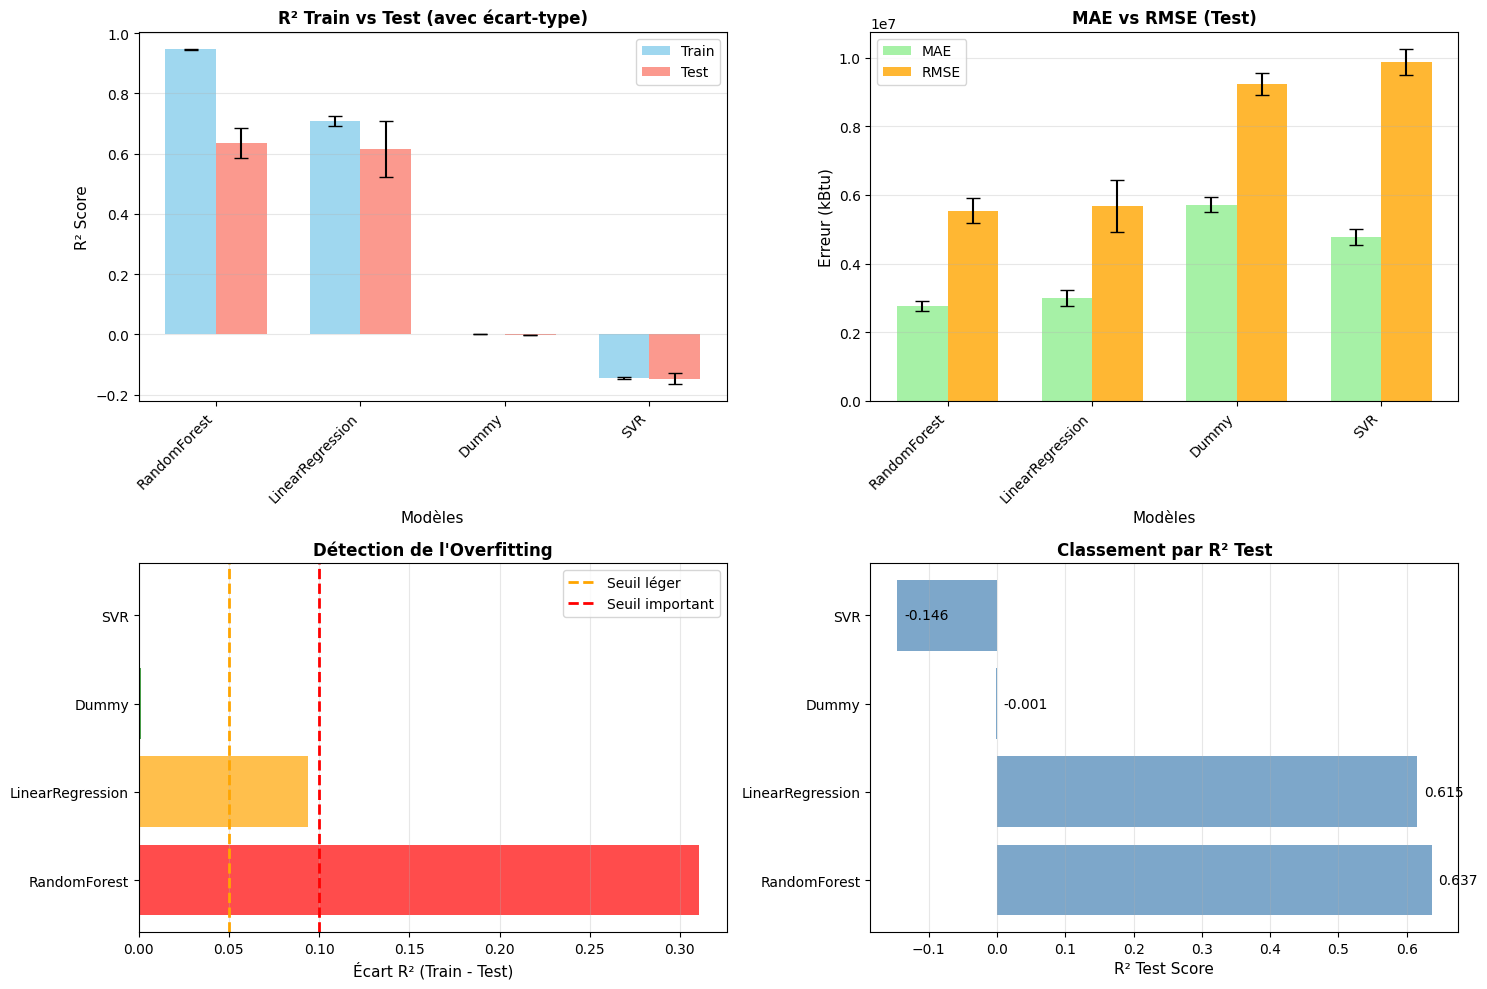

In [81]:
# ============================================
# VISUALISATIONS
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. R² Train vs Test avec barres d'erreur
ax1 = axes[0, 0]
x_pos = np.arange(len(results_df))
width = 0.35

ax1.bar(x_pos - width/2, results_df['r2_train_mean'], width, 
        yerr=results_df['r2_train_std'], label='Train', 
        alpha=0.8, color='skyblue', capsize=5)
ax1.bar(x_pos + width/2, results_df['r2_test_mean'], width, 
        yerr=results_df['r2_test_std'], label='Test', 
        alpha=0.8, color='salmon', capsize=5)

ax1.set_xlabel('Modèles', fontsize=11)
ax1.set_ylabel('R² Score', fontsize=11)
ax1.set_title('R² Train vs Test (avec écart-type)', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['model_name'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. MAE et RMSE avec barres d'erreur
ax2 = axes[0, 1]
ax2.bar(x_pos - width/2, results_df['mae_test_mean'], width, 
        yerr=results_df['mae_test_std'], label='MAE', 
        alpha=0.8, color='lightgreen', capsize=5)
ax2.bar(x_pos + width/2, results_df['rmse_test_mean'], width, 
        yerr=results_df['rmse_test_std'], label='RMSE', 
        alpha=0.8, color='orange', capsize=5)

ax2.set_xlabel('Modèles', fontsize=11)
ax2.set_ylabel('Erreur (kBtu)', fontsize=11)
ax2.set_title('MAE vs RMSE (Test)', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(results_df['model_name'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Écart R² (overfit)
ax3 = axes[1, 0]
colors = ['green' if x < 0.05 else 'orange' if x < 0.10 else 'red' 
          for x in results_df['ecart_r2']]
ax3.barh(results_df['model_name'], results_df['ecart_r2'], color=colors, alpha=0.7)
ax3.axvline(x=0.05, color='orange', linestyle='--', linewidth=2, label='Seuil léger')
ax3.axvline(x=0.10, color='red', linestyle='--', linewidth=2, label='Seuil important')
ax3.set_xlabel('Écart R² (Train - Test)', fontsize=11)
ax3.set_title('Détection de l\'Overfitting', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# 4. Comparaison globale R² Test
ax4 = axes[1, 1]
ax4.barh(results_df['model_name'], results_df['r2_test_mean'], 
         color='steelblue', alpha=0.7)
ax4.set_xlabel('R² Test Score', fontsize=11)
ax4.set_title('Classement par R² Test', fontsize=12, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, (idx, row) in enumerate(results_df.iterrows()):
    ax4.text(row['r2_test_mean'] + 0.01, i, f"{row['r2_test_mean']:.3f}", 
             va='center', fontsize=10)

plt.tight_layout()
plt.show()